In [1]:
import numpy as np
import pysindy as ps
import h5py, tqdm
from tqdm import trange
from sklearn.linear_model import LinearRegression
import func_timeout
import warnings
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
warnings.filterwarnings("ignore", category=UserWarning)

## 1. Data preparation and model training

### Load in data and preprocess

In [2]:
n_data = 3000
d = h5py.File("data\\ref_data_train.jld", "r")
ref_data = d['ref_data_train'][:]
ref_params = d['ref_params_train'][:]
t = d['times_train'][:]
times = t.copy()
dt = 60

In [3]:
ref_param = np.empty((len(ref_params), 9))
for i in range(len(ref_params)):
    for j in range(9):
        ref_param[i,j] = ref_params[i][j]
ref_params = ref_param

In [4]:
EO = 1.48
ref_data[:,:,5] = EO * ref_data[:,:,5]

### PCA

In [5]:
# Importing standardscalar module 
from sklearn.preprocessing import StandardScaler
  
scalar = StandardScaler(with_std=False)
reshaped_data = np.concatenate([ref_data[i] for i in range(ref_data.shape[0])])
# fitting
scalar.fit(reshaped_data)
scaled_data = scalar.transform(reshaped_data)



# Importing PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca.fit(scaled_data)
x_pca = [pca.transform(scaled_data[i*48: i*48+48, :]) for i in range(ref_data.shape[0])]
x = np.concatenate(x_pca)

In [6]:
sum(pca.explained_variance_ratio_)

0.9996852283064168

In [7]:
data = x_pca

### Try only using 3 pcs as library

In [8]:
optimizer = ps.STLSQ(threshold=3.29e-5)
feature_library = ps.PolynomialLibrary(degree=5)
model = ps.SINDy(feature_names=["x", "y", "z"],optimizer=optimizer,feature_library=feature_library)
model.fit(data, t=dt, multiple_trajectories = True)
model.print()

(x)' = 0.001 y^3 + -0.002 y^2 z + 0.012 y z^2 + -0.001 x^2 z^2 + -0.001 y^4 + -0.006 y^3 z + 0.004 y^2 z^2 + -0.059 y z^3 + -0.004 z^4 + 0.001 x^3 y z + 0.001 x^2 y^2 z + 0.005 x^2 z^3 + 0.001 x y^3 z + -0.002 x z^4 + 0.011 y^4 z + -0.020 y^3 z^2 + 0.049 y^2 z^3 + 0.052 y z^4 + 0.003 z^5
(y)' = -0.001 1 + -0.004 y + -0.022 z + 0.009 y^2 + -0.015 y z + 0.037 z^2 + 0.001 x y z + 0.028 y^3 + 0.061 y^2 z + 0.240 y z^2 + 0.739 z^3 + -0.001 x^2 y z + -0.002 x y^3 + -0.006 x y^2 z + -0.068 y^4 + -0.250 y^3 z + -0.285 y^2 z^2 + -0.635 y z^3 + -4.652 z^4 + 0.002 x^2 y^2 z + 0.004 x^2 z^3 + 0.001 x y^4 + 0.005 x y^3 z + 0.013 x y^2 z^2 + -0.008 x y z^3 + 0.037 y^5 + 0.222 y^4 z + 0.141 y^3 z^2 + 0.317 y^2 z^3 + -0.021 y z^4 + 7.666 z^5
(z)' = 0.004 y + 0.007 z + -0.007 y^2 + 0.022 y z + -0.057 z^2 + 0.002 x z^2 + -0.022 y^3 + -0.011 y^2 z + -0.107 y z^2 + -0.439 z^3 + -0.001 x^2 z^2 + 0.001 x y^3 + 0.001 x y^2 z + 0.006 x y z^2 + -0.019 x z^3 + 0.054 y^4 + 0.044 y^3 z + 0.289 y^2 z^2 + -0.600 y 

Execution time for 2 days simulation: 0.7409374713897705 seconds


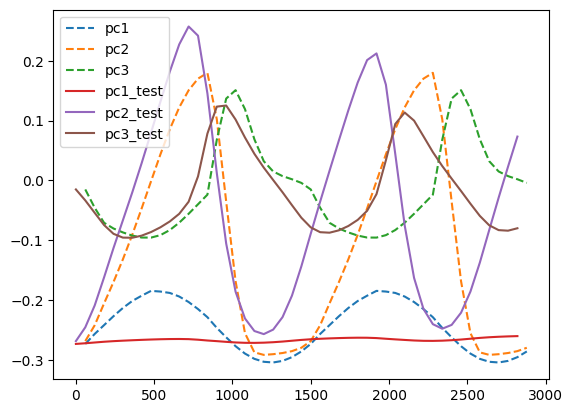

In [9]:
import matplotlib.pyplot as plt
import matplotlib
idx = 9
ttest = np.arange(0, 2880, dt)
import time
start = time.time()
sim = model.simulate(data[idx][0], ttest)
end = time.time()
print('Execution time for 2 days simulation:', end-start, 'seconds')
plt.plot(t-1440, data[idx], label = ["pc1", "pc2", "pc3"], linestyle='dashed')
plt.plot(ttest, sim, label = ["pc1_test", "pc2_test", "pc3_test"])
plt.legend()

### Construct libraries for E-SINDy

In [10]:
### define function for hv and emission along time
def hv_func(hv_shift, t):
    hv_1 = max(np.sin((t + 1500 + hv_shift) / 720 * np.pi - np.pi / 2), 0)
    hv_2 = max((np.sin((t + 1500 + hv_shift) / 720 * np.pi - np.pi / 2)+1.0)/2, 0)
    return np.array([hv_1 * 0.9 + hv_2 * 0.1])

def emission_func(const, init_shift, t):
    return 0.95*const + 0.05*const*np.sin((t +1500) /(1440/2)*np.pi - init_shift)

In [11]:
depositions =     np.array([-0.4/(100*12) * 60, 
    -4/(100*15)* 60,
    -0.5/(100*2) * 60,
    -0.1/(100*2) * 60,
    -0.03/2 * 60,
    -0.1/100 * 60]).reshape(1,6)

In [12]:
# Combine control variables with data
multi_U = []
for i in range(n_data):
    p = np.repeat(ref_params[i,0], t.shape[0])
    T = np.repeat(ref_params[i,1], t.shape[0])
    Tp =p*T
    depo = np.repeat(depositions, t.shape[0], axis=0)
    hv = np.concatenate([hv_func( ref_params[i,-1], ti) for ti in t-1500])
    emission1 = 0.001 * np.stack([emission_func( ref_params[i,2], ref_params[i,5], ti) for ti in t-1500])
    emission2 = 0.1 * np.stack([emission_func( ref_params[i,3],  ref_params[i,6], ti) for ti in t-1500])
    emission3 = 0.001 * np.stack([emission_func( ref_params[i,4],  ref_params[i,7], ti) for ti in t-1500])
    multi_U.append(np.hstack((emission1.reshape(-1,1), emission2.reshape(-1,1), emission3.reshape(-1,1), depo, hv.reshape(-1,1), Tp.reshape(-1,1))))

# Custome library for U
poly_library = ps.PolynomialLibrary(degree=4, include_bias=False)
library_functions = [lambda x: x]
library_function_names = [
    lambda x: x
]

# lib for emissions
custom_library1 = ps.CustomLibrary(
    library_functions=library_functions, 
    function_names=library_function_names
)

# lib for other parameters
custom_library2 = ps.CustomLibrary(
    library_functions=library_functions, 
    function_names=library_function_names
)

inputs_temp = np.tile([i for i in range(14)], 3)
inputs_per_library = np.reshape(inputs_temp, (3, 14))
inputs_per_library[0, 3:] = 2
inputs_per_library[1, :3] = 3
inputs_per_library[1, 12:] = 11
inputs_per_library[2, :12] = 12
print(inputs_per_library)

tensor_array = [[1, 0, 1]]

generalized_library = ps.GeneralizedLibrary(
    [poly_library, custom_library1, custom_library2],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)

feature_names = ["pc1", "pc2", "pc3", "emission_NO2", "emission_HCHO", "emission_H2O2", "depo1","depo2","depo3","depo4", "depo5", "depo6", "hv", "p*T"]
optimizer = ps.STLSQ(threshold=3.29e-5)
u = np.concatenate(multi_U)
model = ps.SINDy()
dx= np.concatenate(model.differentiate(data, t=dt, multiple_trajectories=True))
generalized_library.fit(np.hstack((x, u)))
lib = generalized_library.transform(np.hstack((x, u)))

[[ 0  1  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 3  3  3  3  4  5  6  7  8  9 10 11 11 11]
 [12 12 12 12 12 12 12 12 12 12 12 12 12 13]]


### Training ensemble model...

In [13]:
# ensemble = True
# lib_ensemble = True
# n_subset = int(0.3 * n_data * 48)
# n_candidates_to_drop = 30
# ensemble_coef = []
# n_features = lib.shape[1]
# COEF_THRESHOLD = 1e-14
# n_models = 1000
# import random
# random.seed(42)
# np.random.seed(42)
# for i in trange(n_models):
#     coef = np.zeros((3, n_features))
#     if ensemble:
#         rand_inds = np.random.choice(range(n_data * 48), n_subset, replace=False)
#         lib_new = np.take(lib, rand_inds, axis=0)
#         dx_new = np.take(dx, rand_inds, axis=0)
#     else:
#         lib_new = lib
#         dx_new = dx
#     if lib_ensemble:
#         keep_inds = np.sort(np.random.choice(range(n_features), n_features - n_candidates_to_drop, replace=False))
#         lib_new = lib_new.take(keep_inds, axis=1)
#     else:
#         keep_inds = range(n_features)

#     optimizer.fit(lib_new, dx_new)
#     coef[:, keep_inds] = optimizer.coef_
#     # Unbias part
#     ind_ = np.abs(coef) > COEF_THRESHOLD
#     coef__ = np.zeros(coef.shape)
#     for i in range(ind_.shape[0]):
#         if np.any(ind_[i]):
#             coef__[i, ind_[i]] = (LinearRegression(fit_intercept=False).fit(lib[:, ind_[i]], dx[:, i]).coef_)
#     ensemble_coef.append(coef__)

In [14]:
# np.save("result\\ensemble_coef_ESINDy_newdata_30per_row_30_col_depo.npy", ensemble_coef)
with open('result\\ensemble_coef_ESINDy_newdata_30per_row_30_col_depo.npy', 'rb') as f:
    ensemble_coef = np.load(f)

### Define inference function with numba for speedup

In [15]:
from numbalsoda import lsoda_sig, lsoda, dop853
import numba as nb

def make_lsoda_func(param):
    @nb.cfunc(lsoda_sig)
    def rhs(t, u, du, p):
        y = nb.carray(u, (3,))
        p_ = nb.carray(p, (8,))
        x0 = y[0]
        x1 = y[1]
        x2 = y[2]

        ## 4th order polynomial
        y_ = np.array([x0, x1, x2, x0**2, x0*x1, x0*x2, x1**2, x1*x2, x2**2, x0**3, x0**2*x1, 
              x0**2*x2, x0*x1**2, x0*x1*x2, x0*x2**2, x1**3, x1**2*x2, x1*x2**2, 
              x2**3, x0**4, x0**3*x1, x0**3*x2, x0**2*x1**2, x0**2*x1*x2, x0**2*x2**2, 
              x0*x1**3, x0*x1**2*x2, x0*x1*x2**2, x0*x2**3, x1**4, x1**3*x2, x1**2*x2**2, x1*x2**3, x2**4])
        hv_shift = p_[-1]
        hv_1 = max(np.sin((t + 1500 + hv_shift) / 720 * np.pi - np.pi / 2), 0)
        hv_2 = max((np.sin((t + 1500 + hv_shift) / 720 * np.pi - np.pi / 2)+1.0)/2, 0)
        hv = np.array([hv_1 * 0.9 + hv_2 * 0.1])

        pT = np.array([p_[6]])
        emission1 = p_[0]
        emission2 = p_[1]
        emission3 = p_[2]
        emission1_shift = p_[3]
        emission2_shift = p_[4]
        emission3_shift = p_[5]
        emission1 = 0.001* np.array([0.95*emission1 + 0.05*emission1*np.sin((t +1500) /(1440/2)*np.pi - emission1_shift)])
        emission2 = 0.1* np.array([0.95*emission2 + 0.05*emission2*np.sin((t +1500) /(1440/2)*np.pi - emission2_shift)])
        emission3 = 0.001* np.array([0.95*emission3 + 0.05*emission3*np.sin((t +1500) /(1440/2)*np.pi - emission3_shift)])
        depos = np.array([-0.4/(100*12) * 60, -4/(100*15)* 60,-0.5/(100*2) * 60,-0.1/(100*2) * 60,-0.03/2 * 60,-0.1/100 * 60])
        ## interleave combinations of hv, p, T with y_
        temp = np.empty(len(y_)*2)
        for idx, (item1, item2) in enumerate(zip(hv*y_, pT*y_)):
            temp[idx*2] = item1
            temp[idx*2+1] = item2

        θ = np.concatenate((y_, emission1,emission2, emission3, depos, hv, pT, temp))
        du[0] = np.sum(param[0,:]*θ)
        du[1] = np.sum(param[1,:]*θ)
        du[2] = np.sum(param[2,:]*θ)
    return rhs


In [16]:
d_train = h5py.File("data\\ref_data_train.jld", "r")
ref_params_train = d_train['ref_params_train'][:]
ref_data_train = d_train['ref_data_train'][:]
times_train = d_train['times_train'][:]
ref_param = np.empty((len(ref_params_train), 9))
for i in range(len(ref_params_train)):
    for j in range(9):
        ref_param[i,j] = ref_params_train[i][j]
ref_params_train = ref_param
ref_data_train[:,:,5] = EO * ref_data_train[:,:,5]
multi_U_train = []
    
for i in range(ref_params_train.shape[0]):
    p = ref_params_train[i][0]
    T = ref_params_train[i][1]
    pT = p*T
    multi_U_train.append(np.concatenate((ref_params_train[i][2:8], [pT], [ref_params_train[i][-1]]), axis = 0))
reshaped_data_train = np.concatenate([ref_data_train[i] for i in range(ref_data_train.shape[0])])
scaled_data_train = scalar.transform(reshaped_data_train)
train_pca = [pca.transform(scaled_data_train[i*24*2: i*24*2+24*2, :]) for i in range(3000)]


### Check training performance and select better ensemble members

In [17]:
# ensemble_pred_train = []
# stable_ensemble_train = []

# for k in trange(len(ensemble_coef)):
#     rhs = make_lsoda_func(ensemble_coef[k])
#     funcptr = rhs.address
#     u0s = np.stack(train_pca)[:,0,:]
#     Us = np.stack(multi_U_train)
#     time_train = times_train-1500
#     @nb.njit(parallel=True)
#     def simulate():
#         sol = np.empty((3000, 48, 3))
#         succ = np.empty(3000)
#         for i in nb.prange(3000):
#             u0 = u0s[i]
#             p = Us[i]
#             usol, success = lsoda(funcptr, u0, time_train, data = p, rtol=1.0e-3, atol=1.0e-6)
#             if len(np.argwhere(np.isnan(usol)))!=0 or np.max(np.abs(usol))>5:
#                 success = 0
#             sol[i] = usol
#             succ[i] = success
#         return sol, succ
#     sims, succ = simulate()
#     ensemble_pred_train.append(sims)
#     stable_ensemble_train.append(succ)

In [18]:
# np.save("result\\1000_ensemble_375_test_ESINDy_train_depo.npy", ensemble_pred_train)
# np.save("result\\1000_ensemble_375_test_ESINDy_stable_train_depo.npy", stable_ensemble_train)
with open("result\\1000_ensemble_375_test_ESINDy_train_depo.npy", 'rb') as f:
        ensemble_pred_train = np.load(f)
with open("result\\1000_ensemble_375_test_ESINDy_stable_train_depo.npy", 'rb') as f:
        stable_ensemble_train = np.load(f)

In [19]:
def calc_rmse(prediction, reference):
    prediction = prediction.copy()
    reference = reference.copy()
    if len(reference.shape) == 3:
        reference[:,:,5] =  reference[:,:,5] / EO
        prediction[:,:,5] =  prediction[:,:,5] / EO
    else:
        reference[:,5] =  reference[:,5] / EO
        prediction[:,5] =  prediction[:,5] / EO
    return np.sqrt(np.mean((prediction - reference)**2))

def calc_rmse_O3(prediction, reference):
    prediction = prediction.copy()
    reference = reference.copy()
    if len(reference.shape) == 3:
        r =  reference[:,:,5] / EO
        p =  prediction[:,:,5] / EO
    else:
        r =  reference[:,5] / EO
        p =  prediction[:,5] / EO
    return np.sqrt(np.mean((p - r)**2))

In [20]:
rmse_train = -np.ones(np.stack(stable_ensemble_train).shape)
rmse_O3_train = -np.ones(np.stack(stable_ensemble_train).shape)
def inv_transform(x):
    return scalar.inverse_transform(pca.inverse_transform(x))


for i in trange(1000):
    for j in range(3000):
        if stable_ensemble_train[i][j]==1:
            if np.max(abs(ensemble_pred_train[i][j]))<5:
                rmse_train[i,j] = calc_rmse(inv_transform(ensemble_pred_train[i][j]),ref_data_train[j])
                rmse_O3_train[i,j] = calc_rmse_O3(inv_transform(ensemble_pred_train[i][j]),ref_data_train[j])
            else:
                stable_ensemble_train[i][j]=0

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:44<00:00,  6.07it/s]


In [21]:
rmse_O3_train[rmse_O3_train==-1]=np.nan
np.nanmean(rmse_O3_train, 1).shape

(1000,)

In [22]:
mean_rmse = np.nanmean(rmse_O3_train, 1)
threshold = np.percentile(mean_rmse, 10)
ind = np.where((mean_rmse < threshold)==True)[0]

In [23]:
sorted_ind = ind[np.argsort(mean_rmse[ind])]
sorted_ind

array([136, 670, 628, 868, 524, 493, 953, 652, 752, 207, 208, 640, 230,
       492, 604, 755, 882,  83, 180, 821, 197, 221, 375, 141,   3, 512,
       543, 661,  12, 831, 381, 532, 204, 200, 948, 643, 710, 666, 664,
       183,  21, 195, 222,  81, 333, 425, 464, 696, 699, 225, 630, 372,
       719, 450, 678, 785, 913, 410,  53, 443,   7, 147, 458, 872, 905,
       783,  35, 135, 320, 294, 576, 302,  14, 591, 698, 218, 597, 971,
       637, 538,  29, 163, 877, 663, 349, 388, 791, 155, 281, 642, 964,
       376, 476, 387, 479, 189, 890, 592, 211, 395], dtype=int64)

In [24]:
nan_mask = np.isnan(rmse_O3_train)
# Count the number of NaN values in each row
nan_count_per_row = np.sum(nan_mask, axis=1)

# Calculate the percentage of !NaN values in each row
nan_percentage_per_row = (1 - nan_count_per_row / 1000) * 100

idxes_stability = np.where(nan_percentage_per_row>=100)
rmean = np.nanmean(rmse_O3_train, 1)
min_rmse = np.min(rmean[idxes_stability[0]])
ind_best = [idxes_stability[0][np.argmin(rmean[idxes_stability[0]])]]

## 2. Check E-SINDy model testing accuracy

### Prepare testing data

In [25]:
d_test = h5py.File("data\\ref_data_test.jld", "r")
ref_params_test = d_test['ref_params_test'][:]
ref_data_test = d_test['ref_data_test'][:]
times_test = d_test['times_test'][:]

In [26]:
ref_param = np.empty((len(ref_params_test), 9))
for i in range(len(ref_params_test)):
    for j in range(9):
        ref_param[i,j] = ref_params_test[i][j]
ref_params_test = ref_param

In [27]:
ref_data_test[:,:,5] = EO * ref_data_test[:,:,5]

In [28]:
multi_U_test1 = []
    
for i in range(ref_params_test.shape[0]):
    p = ref_params_test[i][0]
    T = ref_params_test[i][1]
    pT = p*T
    multi_U_test1.append(np.concatenate((ref_params_test[i][2:8], [pT], [ref_params_test[i][-1]]), axis = 0))

In [29]:
reshaped_data_test = np.concatenate([ref_data_test[i] for i in range(ref_data_test.shape[0])])
scaled_data_test = scalar.transform(reshaped_data_test)
test_pca = [pca.transform(scaled_data_test[i*24*9: i*24*9+24*9, :]) for i in range(375)]

In [30]:
## reconstruction error
np.sqrt(np.mean((np.stack([scalar.inverse_transform(pca.inverse_transform(test_pca[i])) for i in range(375)])-ref_data_test[:375])**2))

0.0024755079057437444

### Check the performance of best ensemble member or ensemble coefficients median or their mean 

In [31]:
mean_ensemble = np.mean(ensemble_coef, axis=0)
median_ensemble = np.median(ensemble_coef, axis=0)
best_ensemble = ensemble_coef[ind_best[0]]
rhs = make_lsoda_func(best_ensemble)
funcptr = rhs.address
u0s = np.stack(test_pca)[:,0,:]
Us = np.stack(multi_U_test1)
time_test = times_test-1500
@nb.njit(parallel=True)
def simulate():
    sol = np.empty((375, 216, 3))
    succ = np.empty(375)
    for i in nb.prange(375):
        u0 = u0s[i]
        p = Us[i]
        usol, success = lsoda(funcptr, u0, time_test, data = p, rtol=1.0e-3, atol=1.0e-6)
        if len(np.argwhere(np.isnan(usol)))!=0 or np.max(np.abs(usol))>5:
            success = 0
        sol[i] = usol
        succ[i] = success
    return sol, succ
sims, succ = simulate()

In [32]:
case_nan = np.unique(np.argwhere(np.isnan(sims))[:,0])
print(case_nan)
mask = np.ones(375, np.bool_)
mask[case_nan] = 0

[]


In [33]:
pred_best = np.stack([inv_transform(x) for x in sims])

In [34]:
rmse = calc_rmse(pred_best, ref_data_test)
rmse_inc = -(rmse - 0.05830)/0.05830 *100
rmse_O3 = calc_rmse_O3(pred_best, ref_data_test)
rmse_inc_O3 = -(rmse_O3 - 0.03398)/0.03398 *100

# RMSE of original species
print(round(rmse, 4))
# improvement RMSE of original species as compared to SINDy
print(round(rmse_inc, 1))
# RMSE of ozone
print(round(rmse_O3, 4))
# improvement RMSE of ozone as compared to SINDy
print(round(rmse_inc_O3, 1))

0.0296
49.3
0.0179
47.2


### Check the performance of all 1000 ensemble members

In [35]:
u0s = np.stack(train_pca)[:,0,:]
Us = np.stack(multi_U_train)

In [36]:
# ensemble_pred = []
# stable_ensemble = []
# for i in trange(len(ensemble_coef)):
#     rhs = make_lsoda_func(ensemble_coef[i])
#     funcptr = rhs.address
#     u0s = np.stack(test_pca)[:,0,:]
#     Us = np.stack(multi_U_test1)
#     time_test = times_test-1500
#     @nb.njit(parallel=True)
#     def simulate():
#         sol = np.empty((375, 216, 3))
#         succ = np.empty(375)
#         for i in nb.prange(375):
#             u0 = u0s[i]
#             p = Us[i]
#             usol, success = lsoda(funcptr, u0, time_test, data = p, rtol=1.0e-3, atol=1.0e-6)
#             if len(np.argwhere(np.isnan(usol)))!=0 or np.max(np.abs(usol))>5:
#                 success = 0
#             sol[i] = usol
#             succ[i] = success
#         return sol, succ
#     sims, succ = simulate()
#     ensemble_pred.append(sims)
#     stable_ensemble.append(succ)

In [37]:
# np.save("result\\1000_ensemble_375_test_ESINDy_depo.npy", ensemble_pred)
# np.save("result\\1000_ensemble_375_test_ESINDy_stable_depo.npy", stable_ensemble)
with open("result\\1000_ensemble_375_test_ESINDy_depo.npy", 'rb') as f:
        ensemble_pred = np.load(f)
with open("result\\1000_ensemble_375_test_ESINDy_stable_depo.npy", 'rb') as f:
        stable_ensemble = np.load(f)

In [38]:
mean_sims = []
above_sims = []
below_sims = []
for j in trange(375):
    temp = []
    for i in range(1000):
        if stable_ensemble[i][j]==1:
            if np.max(abs(ensemble_pred[i][j]))<5:
                temp.append(inv_transform(ensemble_pred[i][j]))
            else:
                stable_ensemble[i][j]=0
    mean_sims.append(np.mean(temp, axis=0))

100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [00:09<00:00, 37.91it/s]


In [39]:
rmse = calc_rmse(np.stack(mean_sims), ref_data_test)
rmse_inc = -(rmse - 0.05830)/0.05830 *100
rmse_O3 = calc_rmse_O3(np.stack(mean_sims), ref_data_test)
rmse_inc_O3 = -(rmse_O3 - 0.03398)/0.03398 *100

# RMSE of original species
print(round(rmse, 4))
# improvement RMSE of original species as compared to SINDy
print(round(rmse_inc, 1))
# RMSE of ozone
print(round(rmse_O3, 4))
# improvement RMSE of ozone as compared to SINDy
print(round(rmse_inc_O3, 1))
# stable solution rate
print(round(np.sum(stable_ensemble)/1000/375 *100, 0))

0.0449
23.1
0.0333
2.1
52.0


### Check the performance of top 10%best of 1000 ensemble members

In [40]:
ensemble_coef = np.array(ensemble_coef)[ind]

In [41]:
# np.save("result\\ensemble_coef_ESINDy_newdata_30per_row_30_col_depo_top_10.npy", ensemble_coef)

In [42]:
# ensemble_pred = []
# stable_ensemble = []
# for i in trange(len(ensemble_coef)):
#     rhs = make_lsoda_func(ensemble_coef[i])
#     funcptr = rhs.address
#     u0s = np.stack(test_pca)[:,0,:]
#     Us = np.stack(multi_U_test1)
#     time_test = times_test-1500
#     @nb.njit(parallel=True)
#     def simulate():
#         sol = np.empty((375, 216, 3))
#         succ = np.empty(375)
#         for i in nb.prange(375):
#             u0 = u0s[i]
#             p = Us[i]
#             usol, success = lsoda(funcptr, u0, time_test, data = p, rtol=1.0e-3, atol=1.0e-6)
#             if len(np.argwhere(np.isnan(usol)))!=0 or np.max(np.abs(usol))>5:
#                 success = 0
#             sol[i] = usol
#             succ[i] = success
#         return sol, succ
#     sims, succ = simulate()
#     ensemble_pred.append(sims)
#     stable_ensemble.append(succ)

In [43]:
# np.save("result\\1000_ensemble_375_test_ESINDy_top_10_depo.npy", ensemble_pred)
# np.save("result\\1000_ensemble_375_test_ESINDy_stable_top_10_depo.npy", stable_ensemble)

In [44]:
with open("result\\1000_ensemble_375_test_ESINDy_top_10_depo.npy", 'rb') as f:
        ensemble_pred = np.load(f)
with open("result\\1000_ensemble_375_test_ESINDy_stable_top_10_depo.npy", 'rb') as f:
        stable_ensemble = np.load(f)

In [45]:
def calc_rmse(prediction, reference):
    prediction = prediction.copy()
    reference = reference.copy()
    if len(reference.shape) == 3:
        reference[:,:,5] =  reference[:,:,5] / EO
        prediction[:,:,5] =  prediction[:,:,5] / EO
    else:
        reference[:,5] =  reference[:,5] / EO
        prediction[:,5] =  prediction[:,5] / EO
    return np.sqrt(np.mean((prediction - reference)**2))

def calc_rmse_O3(prediction, reference):
    prediction = prediction.copy()
    reference = reference.copy()
    if len(reference.shape) == 3:
        r =  reference[:,:,5] / EO
        p =  prediction[:,:,5] / EO
    else:
        r =  reference[:,5] / EO
        p =  prediction[:,5] / EO
    return np.sqrt(np.mean((p - r)**2))

In [46]:
mse = -np.ones(np.stack(stable_ensemble).shape)
mse_O3 = -np.ones(np.stack(stable_ensemble).shape)
def inv_transform(x):
    return scalar.inverse_transform(pca.inverse_transform(x))


for i in trange(100):
    for j in range(375):
        if stable_ensemble[i][j]==1:
            if np.max(abs(ensemble_pred[i][j]))<5:
                mse[i,j] = calc_rmse(inv_transform(ensemble_pred[i][j]),ref_data_test[j])
                mse_O3[i,j] = calc_rmse_O3(inv_transform(ensemble_pred[i][j]),ref_data_test[j])
            else:
                stable_ensemble[i][j]=0

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.42it/s]


In [47]:
mean_sims = []
above_sims = []
below_sims = []
for j in trange(375):
    temp = []
    for i in range(100):
        if stable_ensemble[i][j]==1:
            if np.max(abs(ensemble_pred[i][j]))<5:
                temp.append(inv_transform(ensemble_pred[i][j]))
            else:
                stable_ensemble[i][j]=0
    mean_sims.append(np.mean(temp, axis=0))

100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:01<00:00, 322.58it/s]


In [48]:
rmse = calc_rmse(np.stack(mean_sims), ref_data_test)
rmse_inc = -(rmse - 0.05830)/0.05830 *100
rmse_O3 = calc_rmse_O3(np.stack(mean_sims), ref_data_test)
rmse_inc_O3 = -(rmse_O3 - 0.03398)/0.03398 *100

# RMSE of original species
print(round(rmse, 4))
# improvement RMSE of original species as compared to SINDy
print(round(rmse_inc, 1))
# RMSE of ozone
print(round(rmse_O3, 4))
# improvement RMSE of ozone as compared to SINDy
print(round(rmse_inc_O3, 1))
# stable solution rate
print(round(np.sum(stable_ensemble)/100/375 *100, 0))

0.0295
49.4
0.0136
59.9
65.0


## 3. Uncertainty quantification
### Check inclusion of reference value in the confidence interval and calibration of uncertainty quantification

In [69]:
CI_percentage = np.linspace(0,95, 20)
CI_percentage

array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.,
       65., 70., 75., 80., 85., 90., 95.])

In [70]:
inclusion_3pc = []
for ci in CI_percentage:
    mean_sims = []
    above_sims = []
    below_sims = []
    for j in trange(375):
        temp = []
        for i in range(100):
            if stable_ensemble[i][j]==1:
                if np.max(abs(ensemble_pred[i][j]))<5:
                    temp.append(ensemble_pred[i][j])
                else:
                    stable_ensemble[i][j]=0
        mean_sims.append(np.mean(temp, axis=0))
        above_sims.append(np.percentile(np.stack(temp), 100-ci/2, axis=0))
        below_sims.append(np.percentile(np.stack(temp), ci/2, axis=0))
    inclusion_3pc.append(np.mean((np.stack(above_sims)>=test_pca) * (np.stack(below_sims)<=test_pca), (0,1)))

100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:00<00:00, 654.51it/s]


In [71]:
np.stack(inclusion_3pc)[::-1,0]

array([0.10903704, 0.18907407, 0.25040741, 0.29851852, 0.3392963 ,
       0.37653086, 0.41195062, 0.44474074, 0.47798765, 0.50991358,
       0.54001235, 0.57183951, 0.60477778, 0.63788889, 0.67166667,
       0.70604938, 0.74283951, 0.78535802, 0.83819753, 0.90045679])

In [73]:
from sklearn.metrics import r2_score
### Calculate reliability or calibration of uncertainty quantification
for i in range(3):
    print(r2_score( CI_percentage/100+0.05 ,np.stack(inclusion_3pc)[::-1,i]))

0.9274873123366257
0.9910749804552533
0.9665174739317429


In [74]:
inclusion_11species = []
for ci in CI_percentage:
    mean_sims = []
    above_sims = []
    below_sims = []
    for j in trange(375):
        temp = []
        for i in range(100):
            if stable_ensemble[i][j]==1:
                if np.max(abs(ensemble_pred[i][j]))<5:
                    temp.append(inv_transform(ensemble_pred[i][j]))
                else:
                    stable_ensemble[i][j]=0
        mean_sims.append(np.mean(temp, axis=0))
        above_sims.append(np.percentile(np.stack(temp), 100-ci/2, axis=0))
        below_sims.append(np.percentile(np.stack(temp), ci/2, axis=0))
    inclusion_11species.append(np.mean((np.stack(above_sims)>=ref_data_test) * (np.stack(below_sims)<=ref_data_test), (0,1)))

100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:03<00:00, 109.38it/s]


In [76]:
def r2_s(y_true, y_pred):
    sst = sum((y_true-np.mean(y_true))**2)
    ssr = sum((y_true-y_pred)**2)
    return 1-ssr/sst

In [78]:
### Calculate reliability or calibration of uncertainty quantification
specs = [ 'NO$_2$', 'HCHO', 'H$_2$O$_2$', 'NO', 'O', 'O$_3$', 'HO$_2$', 'CO', 'H$_2$', 'HO', 'HNO$_3$']
r2_ = []
for i in range(11):
    r2_.append(r2_s( CI_percentage/100+0.05, np.stack(inclusion_11species)[::-1,i]))

In [79]:
import pandas as pd
df = pd.DataFrame([r2_], columns = specs)
df

NO$_2$      HCHO  H$_2$O$_2$        NO         O     O$_3$    HO$_2$  \
0 -1.504085 -1.764203    0.992295  0.052088  0.747862  0.984168  0.899382   

        CO     H$_2$        HO  HNO$_3$  
0  0.78434  0.596664 -0.748979 -0.56133

In [80]:
sorted_array_with_indices = sorted(enumerate(sorted_ind), key=lambda x: x[1])
ranked_ind = [0] * len(sorted_ind)
for rank, (original_index, _) in enumerate(sorted_array_with_indices, start=1):
    ranked_ind[original_index] = rank
ranked_ind = np.array(ranked_ind)-1
## Generate plot of R2_O3 vs number of ensembles
def r2s(grids):
    res = []
    for grid in tqdm.tqdm(grids):
        inclusion_11species = []
        for ci in CI_percentage:
            mean_sims = []
            above_sims = []
            below_sims = []
            for j in range(375):
                temp = []
                for i in ranked_ind[:grid]:
                    if stable_ensemble[i][j]==1:
                        temp.append(inv_transform(ensemble_pred[i][j]))
                mean_sims.append(np.mean(temp, axis=0))
                above_sims.append(np.percentile(np.stack(temp), 100-ci/2, axis=0))
                below_sims.append(np.percentile(np.stack(temp), ci/2, axis=0))
            inclusion_11species.append(np.mean((np.stack(above_sims)>=ref_data_test) * (np.stack(below_sims)<=ref_data_test), (0,1)))
        res.append(r2_s( CI_percentage/100+0.05, np.stack(inclusion_11species)[::-1,specs.index('O$_3$')]))
    return res
grids = np.arange(15, 105, 5)  
r2s_O3 = r2s(grids)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [11:23<00:00, 37.99s/it]


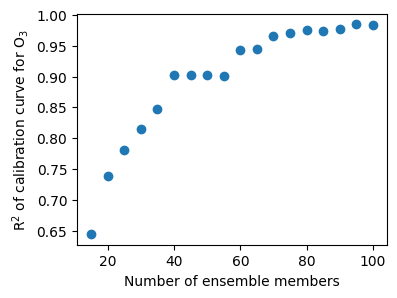

In [81]:
import seaborn as sns
plt.figure(figsize=(4,3))
plt.scatter(grids, r2s_O3)
plt.ylabel("R$^2$ of calibration curve for O$_3$")
plt.xlabel("Number of ensemble members")
plt.savefig('figure\\r2calibration.svg', format='svg', dpi=1200, bbox_inches="tight")
plt.show()

In [84]:
np.mean(inclusion_3pc, 1)

array([0.93831276, 0.88647325, 0.83369959, 0.78460494, 0.73883128,
       0.69675309, 0.65606173, 0.61568724, 0.57607407, 0.53734568,
       0.4986214 , 0.45968313, 0.41896296, 0.37789712, 0.33498765,
       0.29107407, 0.24584362, 0.1963786 , 0.14000823, 0.07618519])

In [85]:
np.mean(inclusion_11species,1)

array([0.67936588, 0.60003591, 0.55150954, 0.51348822, 0.48061728,
       0.45146465, 0.42367789, 0.39662402, 0.36996296, 0.34496184,
       0.32084175, 0.29594052, 0.27148036, 0.24686869, 0.22168799,
       0.19642761, 0.16851178, 0.13798204, 0.10321773, 0.05804377])

In [86]:
np.stack(inclusion_11species)[:,5]

array([0.95434568, 0.90712346, 0.85667901, 0.80628395, 0.75485185,
       0.70503704, 0.65233333, 0.60067901, 0.55041975, 0.50382716,
       0.45735802, 0.41290123, 0.36860494, 0.32606173, 0.2814321 ,
       0.23965432, 0.19441975, 0.14687654, 0.0982716 , 0.04755556])

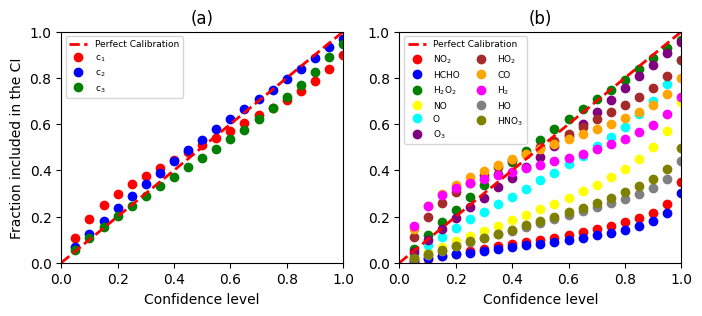

In [132]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,3))

legend_elements1 = [Line2D([0], [0], color='r', linestyle='--', lw=2, label='Perfect Calibration'),
                    Line2D([0], [0], marker='o', color='red', markerfacecolor='red', label='c$_1$', ls = ''),
                  Line2D([0], [0], marker='o', color='blue', markerfacecolor='blue', label='c$_2$', ls = ''),
                  Line2D([0], [0], marker='o', color='green', markerfacecolor='green', label='c$_3$', ls = '')]

    
ax1.set_prop_cycle(color=['red','blue','green'])


colors=['red','blue','green', 'yellow', 'cyan', 'purple', 'brown', 'orange', 'magenta', 'grey', 'olive']
specs = [ 'NO$_2$', 'HCHO', 'H$_2$O$_2$', 'NO', 'O', 'O$_3$', 'HO$_2$', 'CO', 'H$_2$', 'HO', 'HNO$_3$']
n = len(colors)

legend_elements2 = [Line2D([0], [0], color='r', linestyle='--', lw=2, label='Perfect Calibration')]

legend_elements2 += [Line2D([0], [0], marker='o', color=colors[i], markerfacecolor=colors[i], label=specs[i], ls = '') for i in range(n//2+1)]
legend_elements2 += [Patch(color=None, label='', alpha=0)]
legend_elements2 += [Line2D([0], [0], marker='o', color=colors[i], markerfacecolor=colors[i], label=specs[i], ls = '') for i in range(n//2+1, n)]
ax2.set_prop_cycle(color=colors)

for i in range(np.stack(inclusion_3pc).shape[1]):
    ax1.scatter(x_axis, np.stack(inclusion_3pc)[:,i])
for i in range(np.stack(inclusion_11species).shape[1]):
    ax2.scatter(x_axis, np.stack(inclusion_11species)[:,i])

ax1.legend(handles=legend_elements1, loc = 'upper left', prop={'size': 6.5})
ax2.legend(handles=legend_elements2, ncol = 2, prop={'size': 6.5}, columnspacing=-5)
ax1.set_ylabel("Fraction included in the CI")
ax1.set_xlabel("Confidence level")
ax2.set_xlabel("Confidence level")
ax1.set_xlim(0, 1.0)
ax2.set_xlim(0, 1.0)
ax1.set_ylim(0, 1.0)
ax2.set_ylim(0, 1.0)
ax1.set_title("(a)")
ax2.set_title("(b)")
ax1.axline((0, 0), (1, 1), linewidth=2, color='r', linestyle="--")
ax2.axline((0, 0), (1, 1), linewidth=2, color='r', linestyle="--")
# plt.show()

plt.savefig('figure\\calibration.svg', format='svg', dpi=1200, bbox_inches="tight")

In [88]:
np.stack(inclusion_3pc).shape[1]

3

In [89]:
np.mean(inclusion_11species,1)

array([0.67936588, 0.60003591, 0.55150954, 0.51348822, 0.48061728,
       0.45146465, 0.42367789, 0.39662402, 0.36996296, 0.34496184,
       0.32084175, 0.29594052, 0.27148036, 0.24686869, 0.22168799,
       0.19642761, 0.16851178, 0.13798204, 0.10321773, 0.05804377])

In [90]:
np.stack(inclusion_11species)[:,5]

array([0.95434568, 0.90712346, 0.85667901, 0.80628395, 0.75485185,
       0.70503704, 0.65233333, 0.60067901, 0.55041975, 0.50382716,
       0.45735802, 0.41290123, 0.36860494, 0.32606173, 0.2814321 ,
       0.23965432, 0.19441975, 0.14687654, 0.0982716 , 0.04755556])

## 4. Generate plots about specific details
### Plot error percentile and compare with SINDy

In [91]:
mask = np.ones(len(mean_sims), bool)
mask[case_nan] = 0

In [92]:
rhs = make_lsoda_func(best_ensemble)
funcptr = rhs.address
u0s = np.stack(test_pca)[:,0,:]
Us = np.stack(multi_U_test1)
time_test = times_test-1500
@nb.njit(parallel=True)
def simulate():
    sol = np.empty((375, 216, 3))
    succ = np.empty(375)
    for i in nb.prange(375):
        u0 = u0s[i]
        p = Us[i]
        usol, success = lsoda(funcptr, u0, time_test, data = p, rtol=1.0e-3, atol=1.0e-6)
        if len(np.argwhere(np.isnan(usol)))!=0:
            success = 0
        sol[i] = usol
        succ[i] = success
    return sol, succ
sims, succ = simulate()
sims_best = np.stack([inv_transform(x) for x in sims])

In [93]:
d = h5py.File("data\\testing_perform.jld", "r")
SINDy_test = d['ref_data_test'][:]
SINDy_pred = d['test_prediction'][:]
specs_name = d['specs'][:]

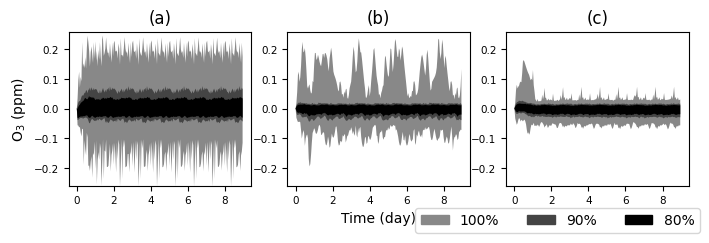

In [96]:
figure, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(8, 2))
ax1.set_prop_cycle(color=['#888','#444','black'])
ax2.set_prop_cycle(color=['#888','#444','black'])
ax3.set_prop_cycle(color=['#888','#444','black'])
legend_elements1 = [Patch(facecolor='#888', edgecolor='#888', label='100%'),
                  Patch(facecolor='#444', edgecolor='#444', label='90%'),
                  Patch(facecolor='black', edgecolor='black', label='80%')]

error_CI = [0, 10, 20]
for ci in error_CI:
    upper = np.percentile((SINDy_pred-SINDy_test)[:,:,5],100-ci/2, axis=0)
    lower = np.percentile((SINDy_pred-SINDy_test)[:,:,5],ci/2, axis=0)
    ax1.fill_between((times_test-1500)[:len(upper)]/60/24, lower, upper)
    
for ci in error_CI:
    upper = np.percentile((sims_best-ref_data_test)[:,:,5]/EO,100-ci/2, axis=0)
    lower = np.percentile((sims_best-ref_data_test)[:,:,5]/EO,ci/2, axis=0)
    ax2.fill_between((times_test-1500)[:len(upper)]/60/24, lower, upper)
    
for ci in error_CI:
    upper = np.percentile((np.stack(mean_sims)-ref_data_test)[:,:,5]/EO,100-ci/2, axis=0)
    lower = np.percentile((np.stack(mean_sims)-ref_data_test)[:,:,5]/EO,ci/2, axis=0)
    ax3.fill_between((times_test-1500)[:len(upper)]/60/24, lower, upper)

ax1.xaxis.set_tick_params(labelsize=7.5)
ax1.yaxis.set_tick_params(labelsize=7.5)
ax1.set_ylim(-0.26, 0.26)
ax2.set_ylim(-0.26, 0.26)
ax3.set_ylim(-0.26, 0.26)
ax2.xaxis.set_tick_params(labelsize=7.5)
ax2.yaxis.set_tick_params(labelsize=7.5)
ax3.xaxis.set_tick_params(labelsize=7.5)
ax3.yaxis.set_tick_params(labelsize=7.5)
ax1.set_ylabel("O$_3$ (ppm)")
ax2.set_xlabel("Time (day)")
ax1.set_title("(a)")
ax2.set_title("(b)")
ax3.set_title("(c)")
ax3.legend(handles=legend_elements1, bbox_to_anchor = (1.1, -0.1),ncol=3)

plt.savefig('figure\\epercentile.svg', format='svg', dpi=1200, bbox_inches="tight")

### Plot specific figures with confidence intervals

In [98]:
ci = 5
mean_sims = []
above_sims = []
below_sims = []
for j in trange(375):
    temp = []
    for i in range(100):
        if stable_ensemble[i][j]==1:
            if np.max(abs(ensemble_pred[i][j]))<5:
                temp.append(ensemble_pred[i][j])
            else:
                stable_ensemble[i][j]=0
    mean_sims.append(np.mean(temp, axis=0))
    above_sims.append(np.percentile(np.stack(temp), 100-ci/2, axis=0))
    below_sims.append(np.percentile(np.stack(temp), ci/2, axis=0))

100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:00<00:00, 767.78it/s]


In [99]:
idx=18
below = below_sims[idx]
above = above_sims[idx]
post_mean = mean_sims[idx]

100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 130.89it/s]


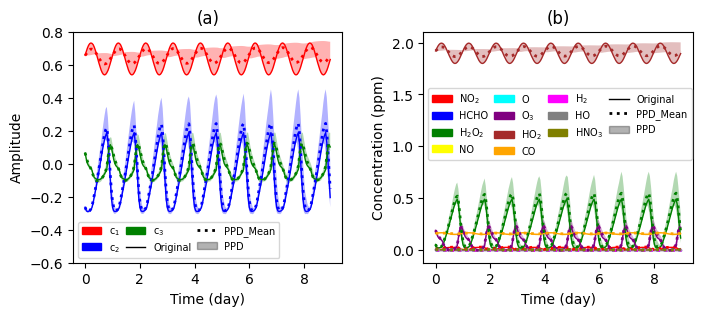

In [100]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements1 = [Patch(facecolor='red', edgecolor='red', label='c$_1$'),
                  Patch(facecolor='blue', edgecolor='blue', label='c$_2$'),
                  Patch(facecolor='green', edgecolor='green', label='c$_3$'),
                    Line2D([0], [0], color='black', lw=1, label='Original'),
                    Line2D([0], [0], color='black', linestyle=':', lw=2,label='PPD_Mean'),
                   Patch(facecolor='black', edgecolor='black', label='PPD', alpha=0.3)]

colors=['red','blue','green']
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(8, 3))
ax1.set_prop_cycle(color=['red','blue','green'])
ax1.plot((times_test-1500)/60/24, test_pca[idx],linewidth=1)
ax1.plot((times_test-1500)[:len(post_mean)]/60/24, post_mean,  linestyle=':', linewidth=2)
ax1.set_ylim(-0.6,0.8)
for k in range(3):
    ax1.fill_between((times_test-1500)/60/24, below[:, k], above[:, k], alpha=0.3)
ax1.set_xlabel('Time (day)')
ax1.set_ylabel('Amplitude')
ax1.legend(handles=legend_elements1, loc = 'lower left', ncol=3, prop={'size': 7}, columnspacing=0.6)

mean_sims = []
above_sims = []
below_sims = []
for j in trange(375):
    temp = []
    for i in range(100):
        if stable_ensemble[i][j]==1:
            if np.max(abs(ensemble_pred[i][j]))<5:
                temp.append(inv_transform(ensemble_pred[i][j]))
            else:
                stable_ensemble[i][j]=0
    mean_sims.append(np.mean(temp, axis=0))
    above_sims.append(np.percentile(np.stack(temp), 100-ci/2, axis=0))
    below_sims.append(np.percentile(np.stack(temp), ci/2, axis=0))
    
idx=18
below = below_sims[idx]
above = above_sims[idx]
post_mean = mean_sims[idx]

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

color=['red','blue','green', 'yellow', 'cyan', 'purple', 'brown', 'orange', 'magenta', 'grey', 'olive']
specs = [ 'NO$_2$', 'HCHO', 'H$_2$O$_2$', 'NO', 'O', 'O$_3$', 'HO$_2$', 'CO', 'H$_2$', 'HO', 'HNO$_3$']
n = len(color)
legend_elements1 = [Patch(facecolor=color[i], edgecolor=color[i], label=specs[i]) for i in range(n)]
legend_elements1 += [Line2D([0], [0], color='black', lw=1, label='Original'),
                    Line2D([0], [0], color='black', linestyle=':', lw=2,label='PPD_Mean'),
                   Patch(facecolor='black', edgecolor='black', label='PPD', alpha=0.3)]

colors=color
ax2.set_prop_cycle(color=colors)
ax2.plot((times_test-1500)/60/24, ref_data_test[idx],linewidth=1)
ax2.plot((times_test-1500)[:len(post_mean)]/60/24, post_mean,  linestyle=':', linewidth=2)

for k in range(11):
    ax2.fill_between((times_test-1500)/60/24, below[:, k], above[:, k], alpha=0.3)
ax2.set_xlabel('Time (day)')
ax2.set_ylabel('Concentration (ppm)')
ax2.legend(handles=legend_elements1, loc = 'center left', bbox_to_anchor = (0, 0.6), ncol=4, prop={'size': 7}, columnspacing=0.6)
ax1.set_title("(a)")
ax2.set_title("(b)")
plt.subplots_adjust(wspace=0.3)
plt.savefig('figure\\testcase.svg', format='svg', dpi=1200, bbox_inches="tight")

In [101]:
rmse_ = np.mean(np.abs((np.stack(mean_sims)-ref_data_test)[:,:,5]/EO), 1)

In [102]:
# Enumerate the list to keep track of the original indices
enum_list = list(enumerate(rmse_))

# Sort the enumerated list based on values
sorted_enum_list = sorted(enum_list, key=lambda x: x[1])

# Find the indices of the 3 smallest values
smallest_indices = [index for index, value in sorted_enum_list[:3]]

# Find the indices of the 3 largest values
largest_indices = [index for index, value in sorted_enum_list[-3:]]

# Find the indices of the 3 median values
list_length = len(sorted_enum_list)
middle = list_length // 2

median_indices = [sorted_enum_list[middle-1][0], sorted_enum_list[middle][0], sorted_enum_list[middle+1][0]]

In [103]:
RMS_O3 = np.sqrt(np.sum((ref_data_test[:,:,5]/EO)**2)/np.prod(ref_data_test[:,:,5].shape))
RMS_O3

0.0902878067870948

In [104]:
mean_O3 = np.mean(ref_data_test[:,:,5]/EO)
mean_O3

0.06472944061070236

In [105]:
print("Small")
print(rmse_[smallest_indices])
print(rmse_[smallest_indices]/RMS_O3 * 100)
print("Median")
print(rmse_[median_indices])
print(rmse_[median_indices]/RMS_O3 * 100)
print("Large")
print(rmse_[largest_indices])
print(rmse_[largest_indices]/RMS_O3 * 100)

Small
[0.00241925 0.00262174 0.00263195]
[2.67949046 2.90375425 2.91507238]
Median
[0.00752125 0.00752506 0.00753372]
[8.33030968 8.3345304  8.34411491]
Large
[0.02970538 0.02988043 0.03088526]
[32.9007615  33.09464861 34.20756976]


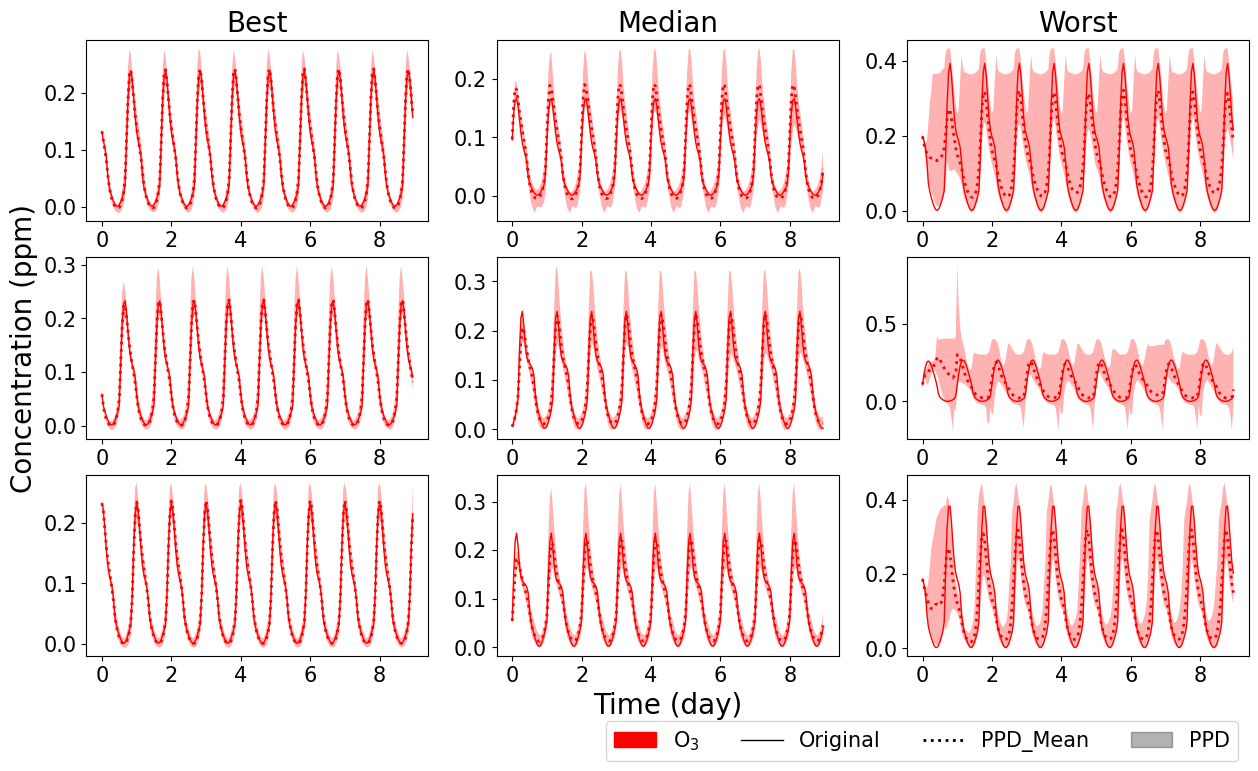

In [107]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

color=['red']
specs = [ 'O$_3$']
n = len(color)
legend_elements1 = [Patch(facecolor=color[i], edgecolor=color[i], label=specs[i]) for i in range(n)]
legend_elements1 += [Line2D([0], [0], color='black', lw=1, label='Original'),
                    Line2D([0], [0], color='black', linestyle=':', lw=2,label='PPD_Mean'),
                   Patch(facecolor='black', edgecolor='black', label='PPD', alpha=0.3)]

colors=color

indexex = [smallest_indices, median_indices, largest_indices]
figure, ax = plt.subplots(3, 3, figsize=(15, 8))
for i in range(3):
    for j in range(3):
        idx = indexex[j][i]

        below = below_sims[idx]
        above = above_sims[idx]
        post_mean = mean_sims[idx]
        sim = inv_transform(sims[idx])

        k = 5
        ax[i,j].set_prop_cycle(color=colors)
        ax[i,j].plot((times_test-1500)/60/24, ref_data_test[idx][:,k],linewidth=1)
        ax[i,j].plot((times_test-1500)[:len(post_mean)]/60/24, post_mean[:,k],  linestyle=':', linewidth=2)


        ax[i,j].fill_between((times_test-1500)[:len(sim)]/60/24, below[:, k], above[:, k], alpha=0.3)
        ax[i,j].xaxis.set_tick_params(labelsize=15)
        ax[i,j].yaxis.set_tick_params(labelsize=15)
        if i==2 and j==1:
            ax[i,j].set_xlabel('Time (day)', fontsize=20)
        if j==0 and i==1:
            ax[i,j].set_ylabel('Concentration (ppm)', fontsize=20)
        if i==0 and j==0:
            ax[i,j].set_title('Best', fontsize=20)
        if i==0 and j==1:
            ax[i,j].set_title('Median', fontsize=20)
        if i==0 and j==2:
            ax[i,j].set_title('Worst', fontsize=20)
plt.legend(handles=legend_elements1, bbox_to_anchor=(1.0,-0.3), ncol=4, fontsize = 15)
plt.savefig('figure\\bestmedianworst.svg', format='svg', dpi=1200, bbox_inches="tight")

In [108]:
d = h5py.File("data\\testing_perform.jld", "r")
SINDy_test = d['ref_data_test'][:]
SINDy_pred = d['test_prediction'][:]
specs_name_ = [x[0].decode('UTF-8') for x in d['specs'][:]]

In [109]:
specs_name = [ 'NO$_2$', 'HCHO', 'H$_2$O$_2$', 'NO', 'O', 'O$_3$', 'HO$_2$', 'CO', 'H$_2$', 'HO', 'HNO$_3$']

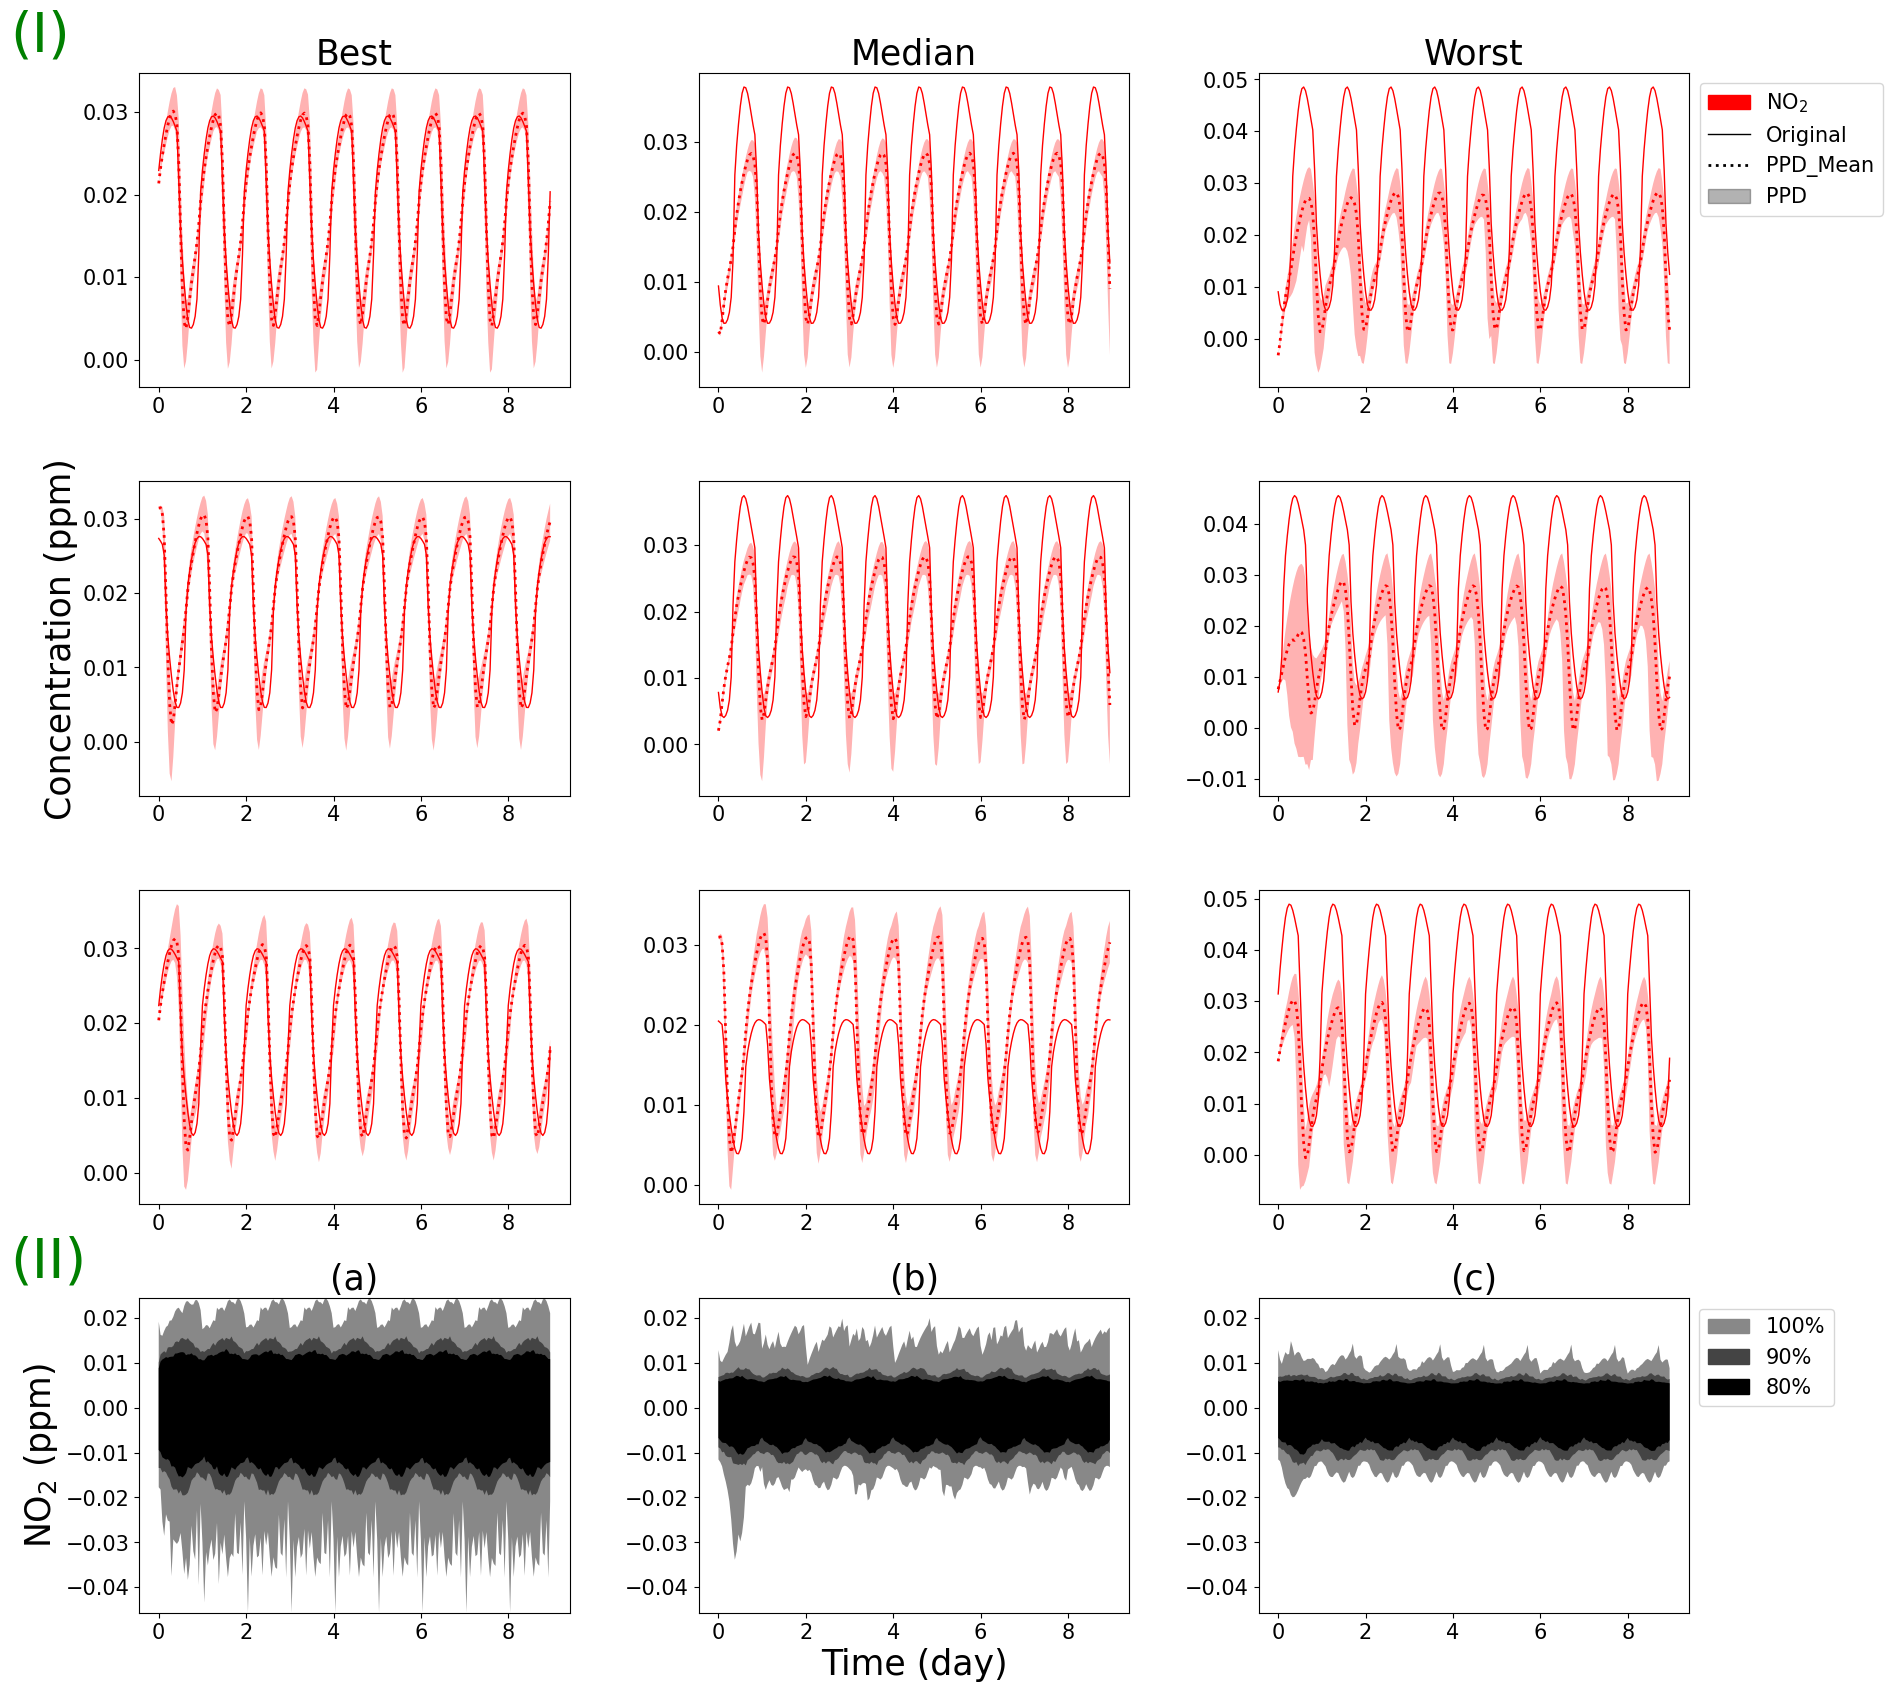

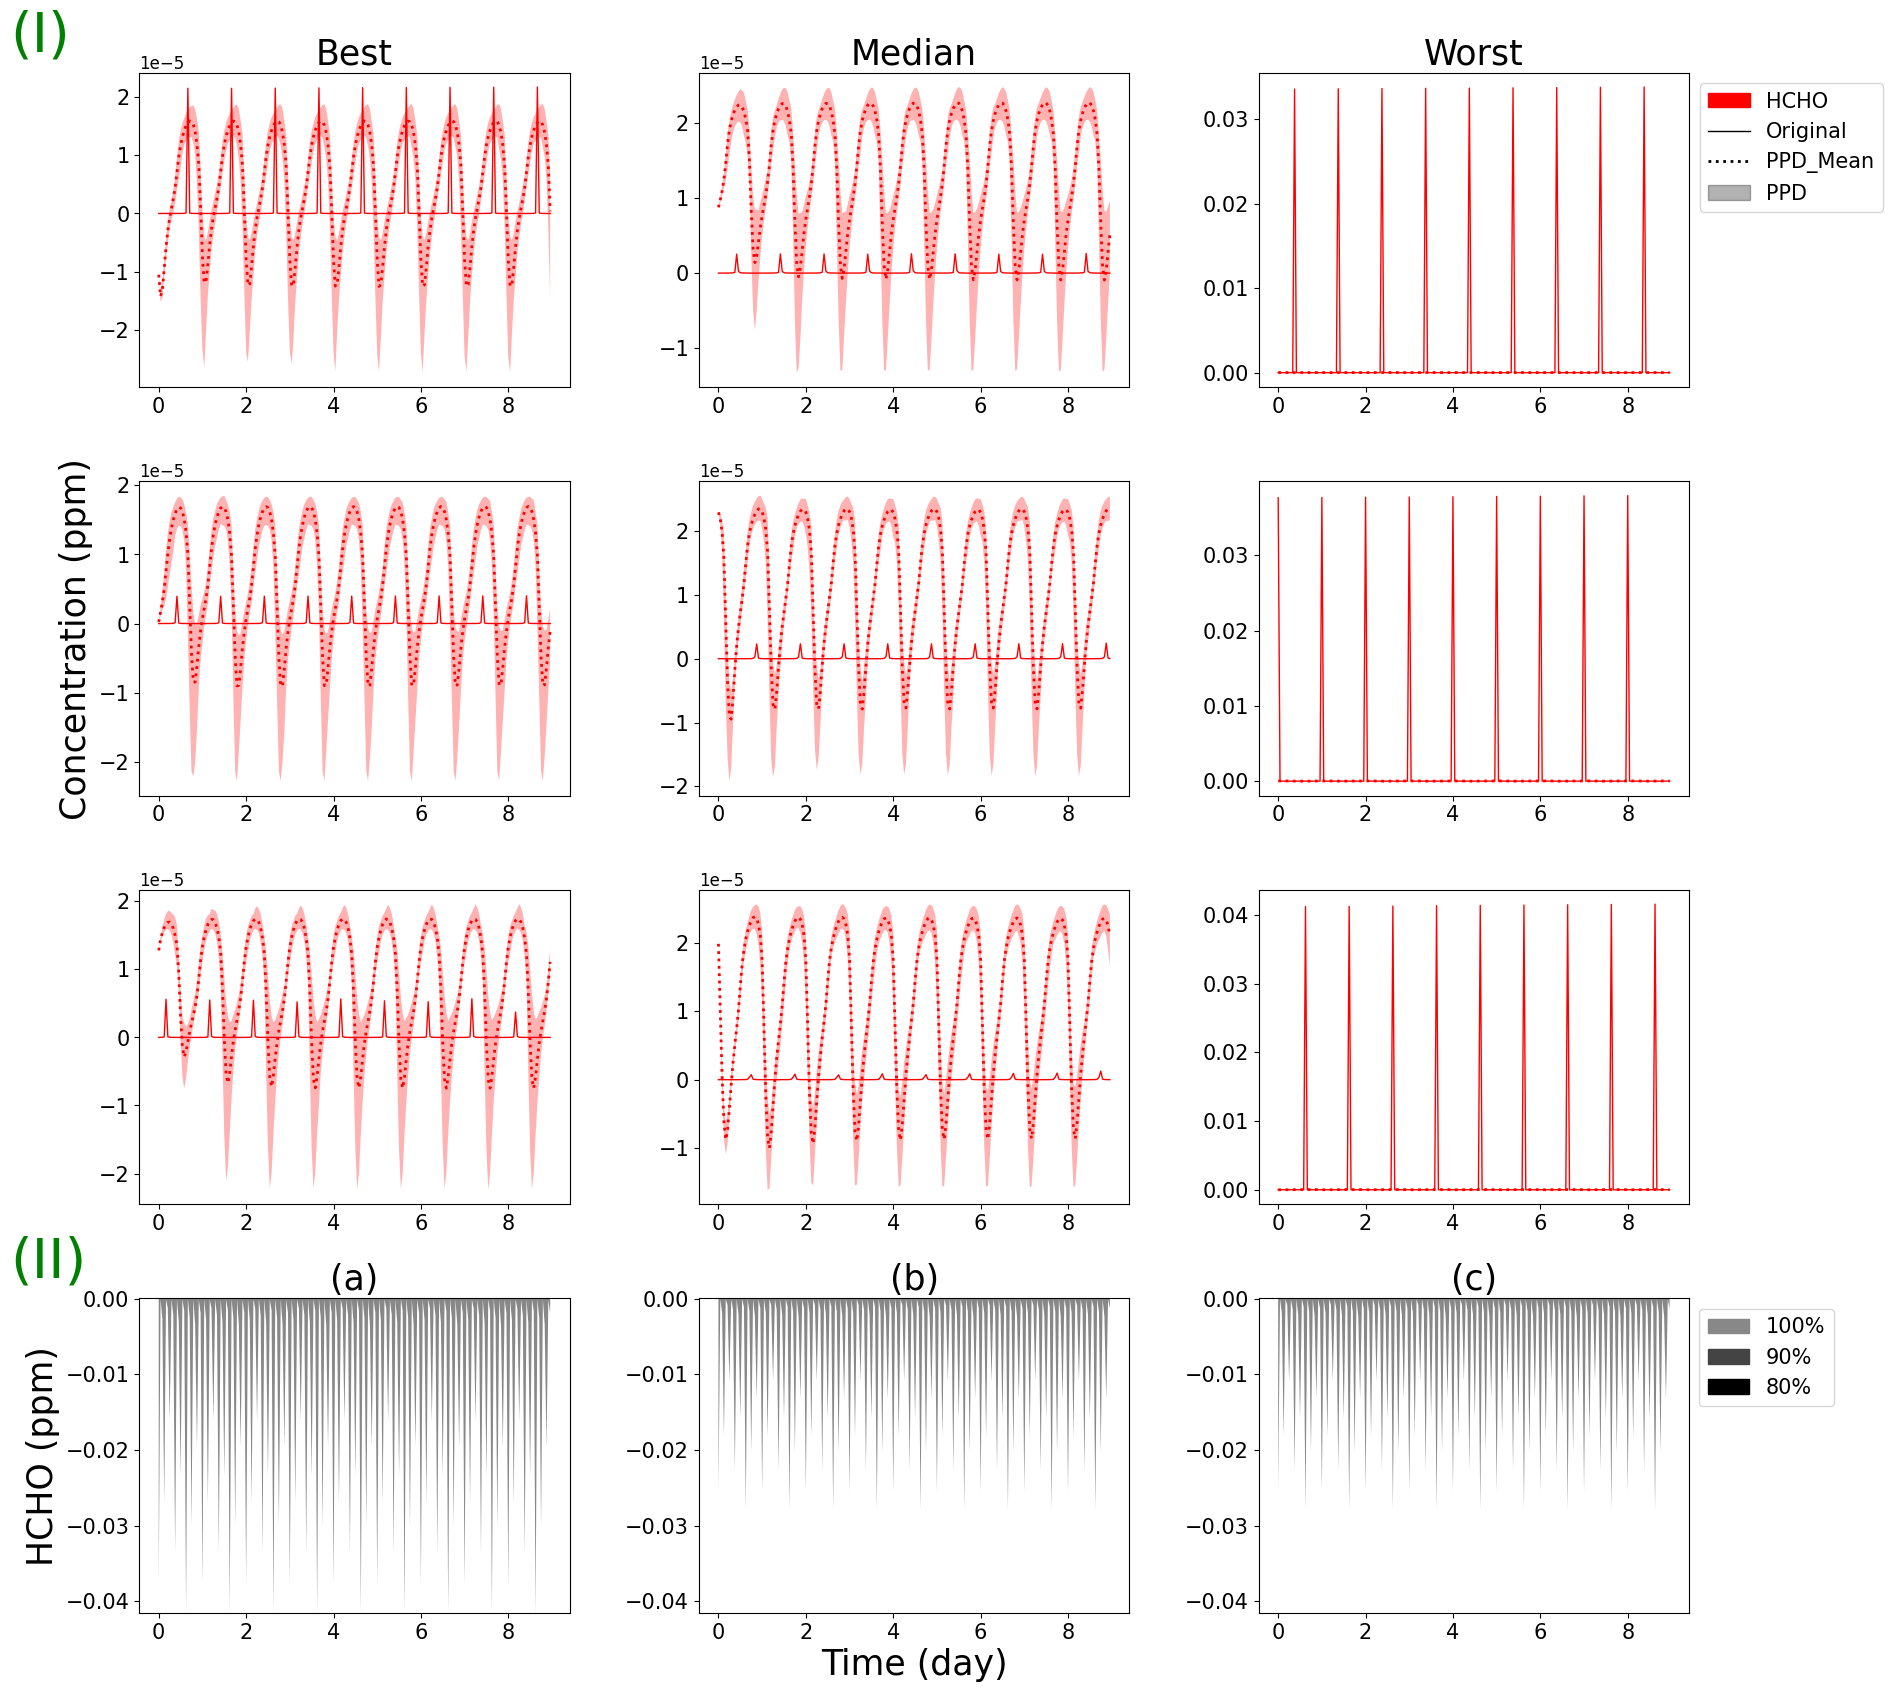

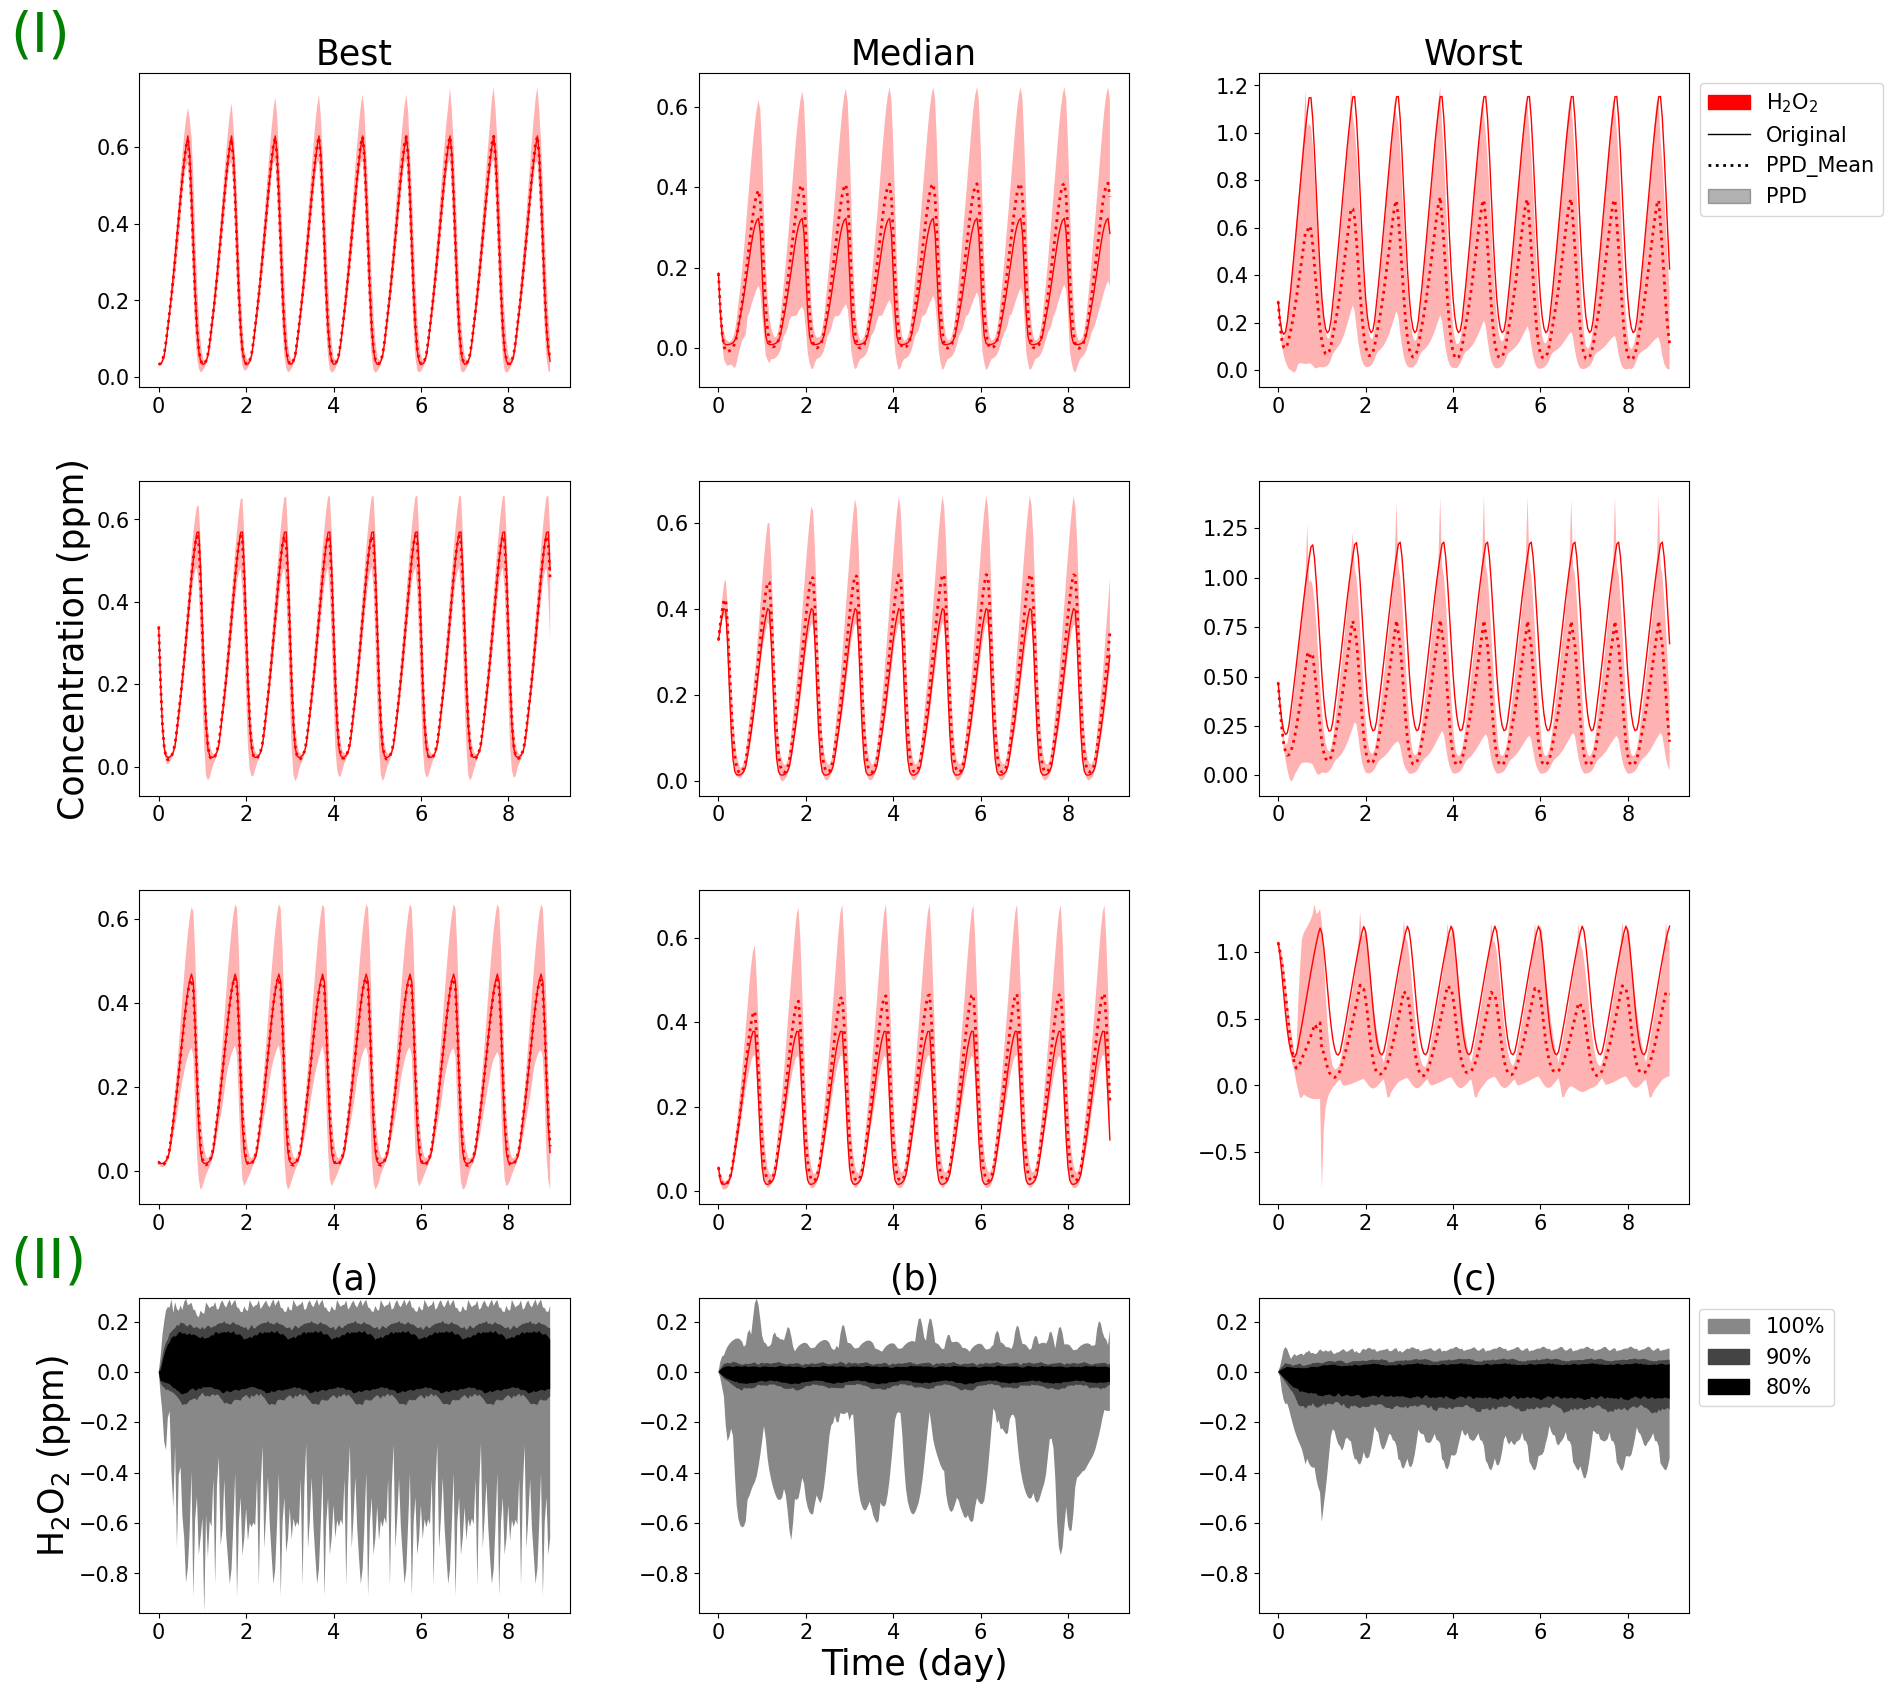

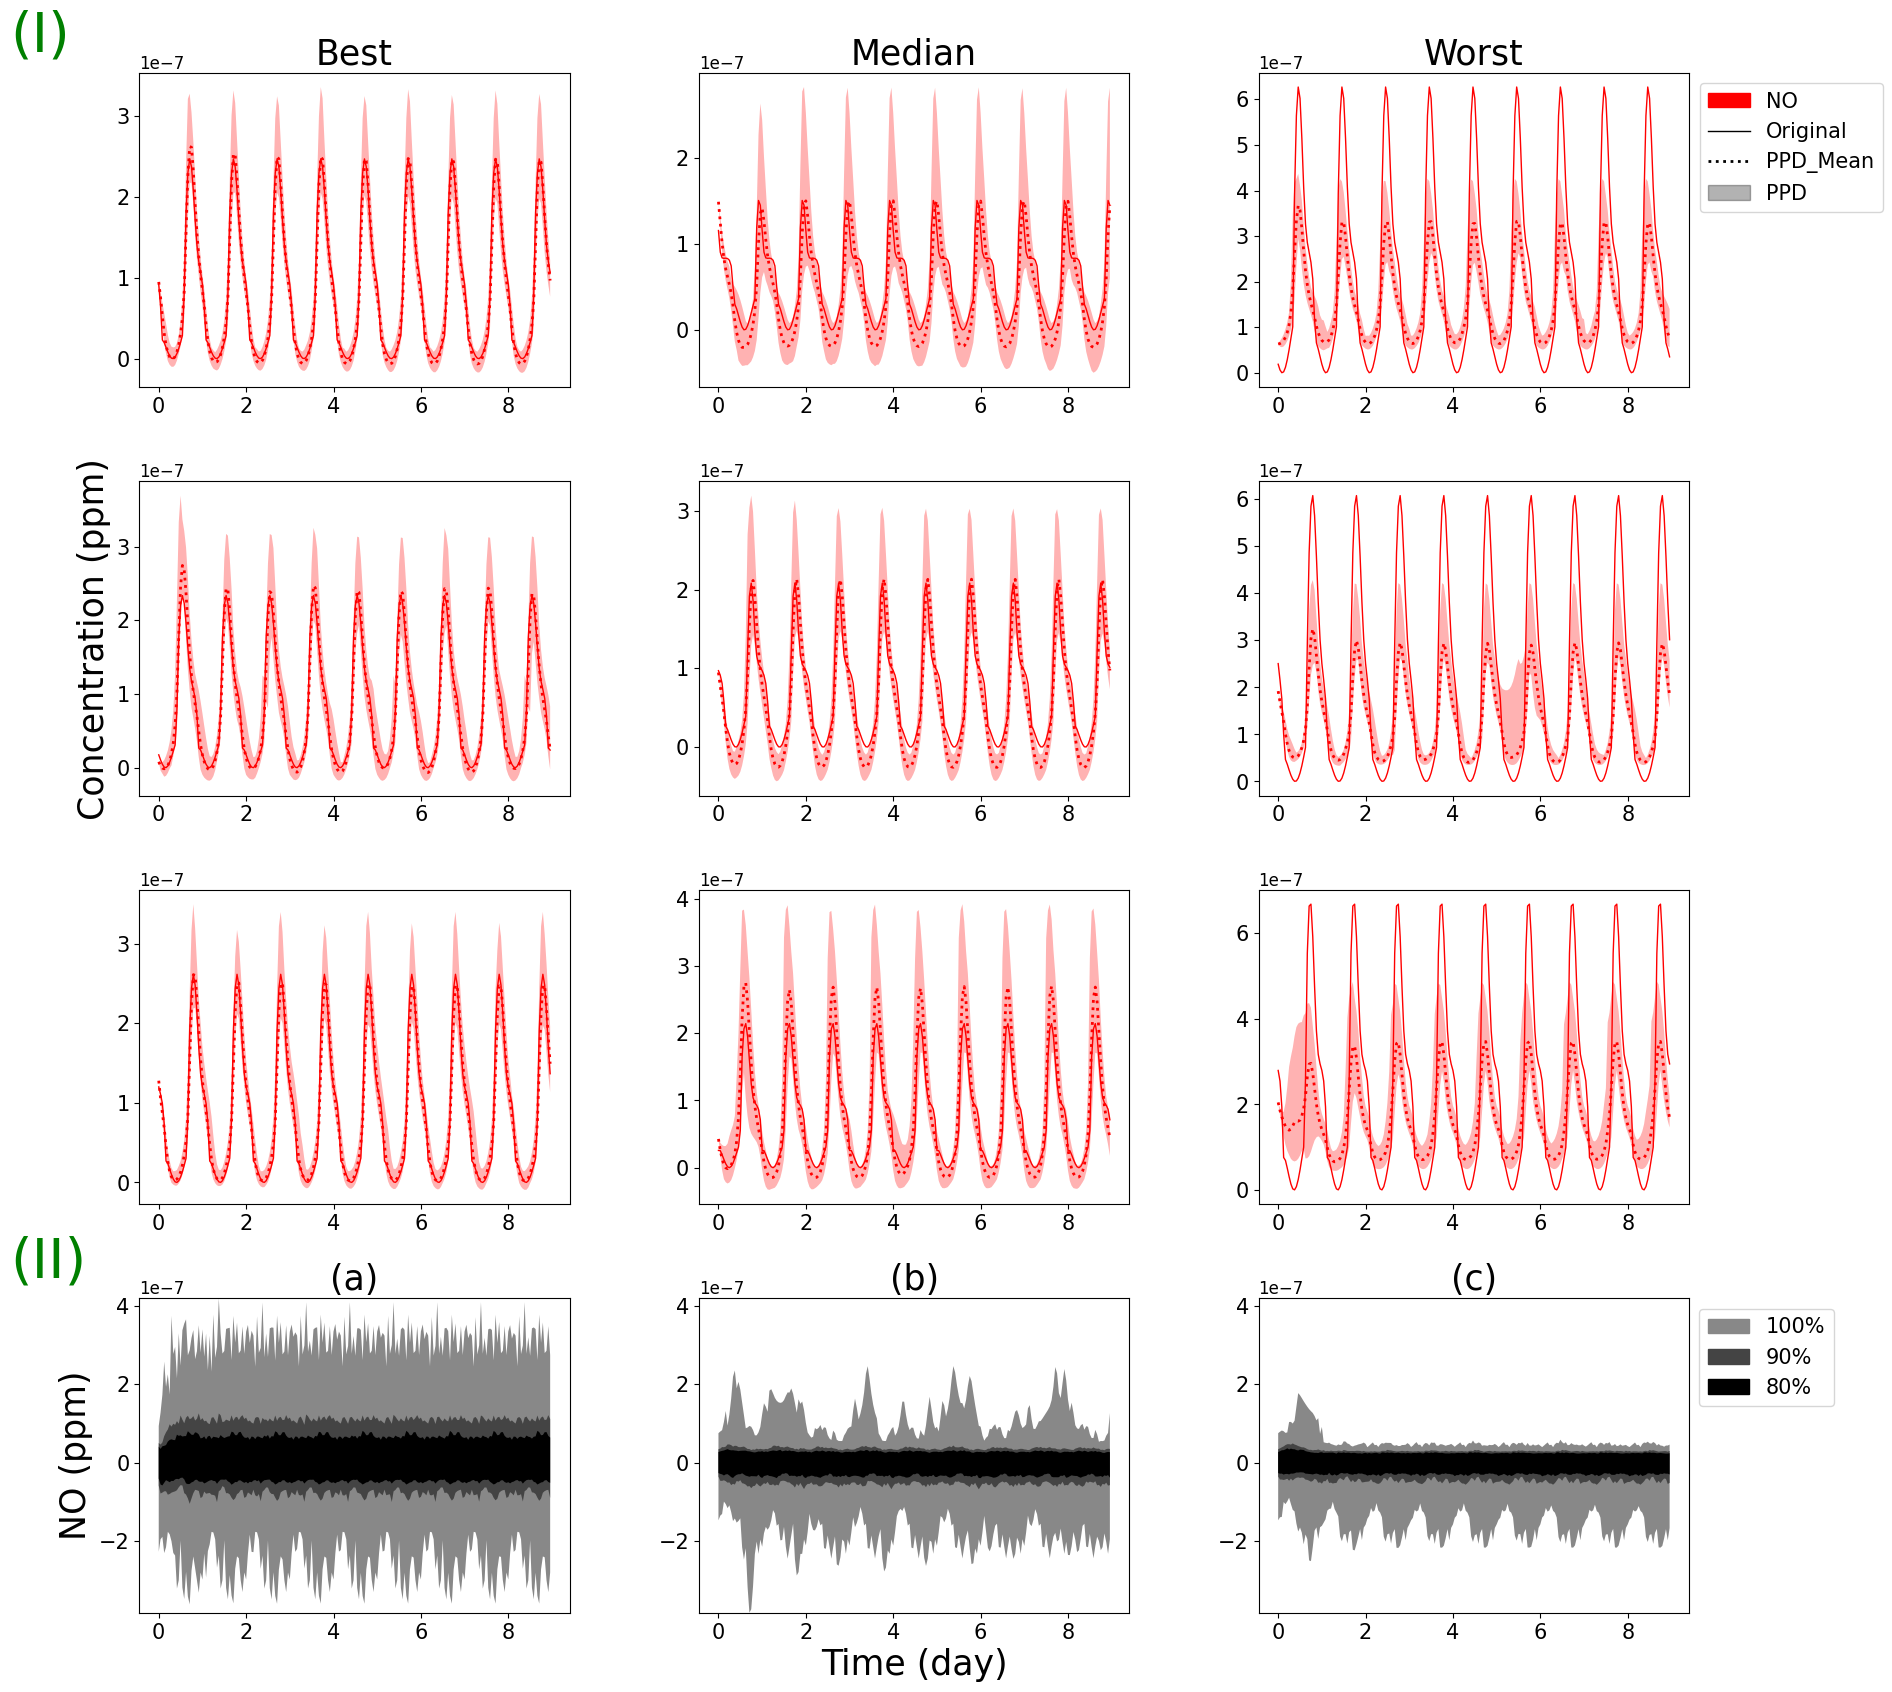

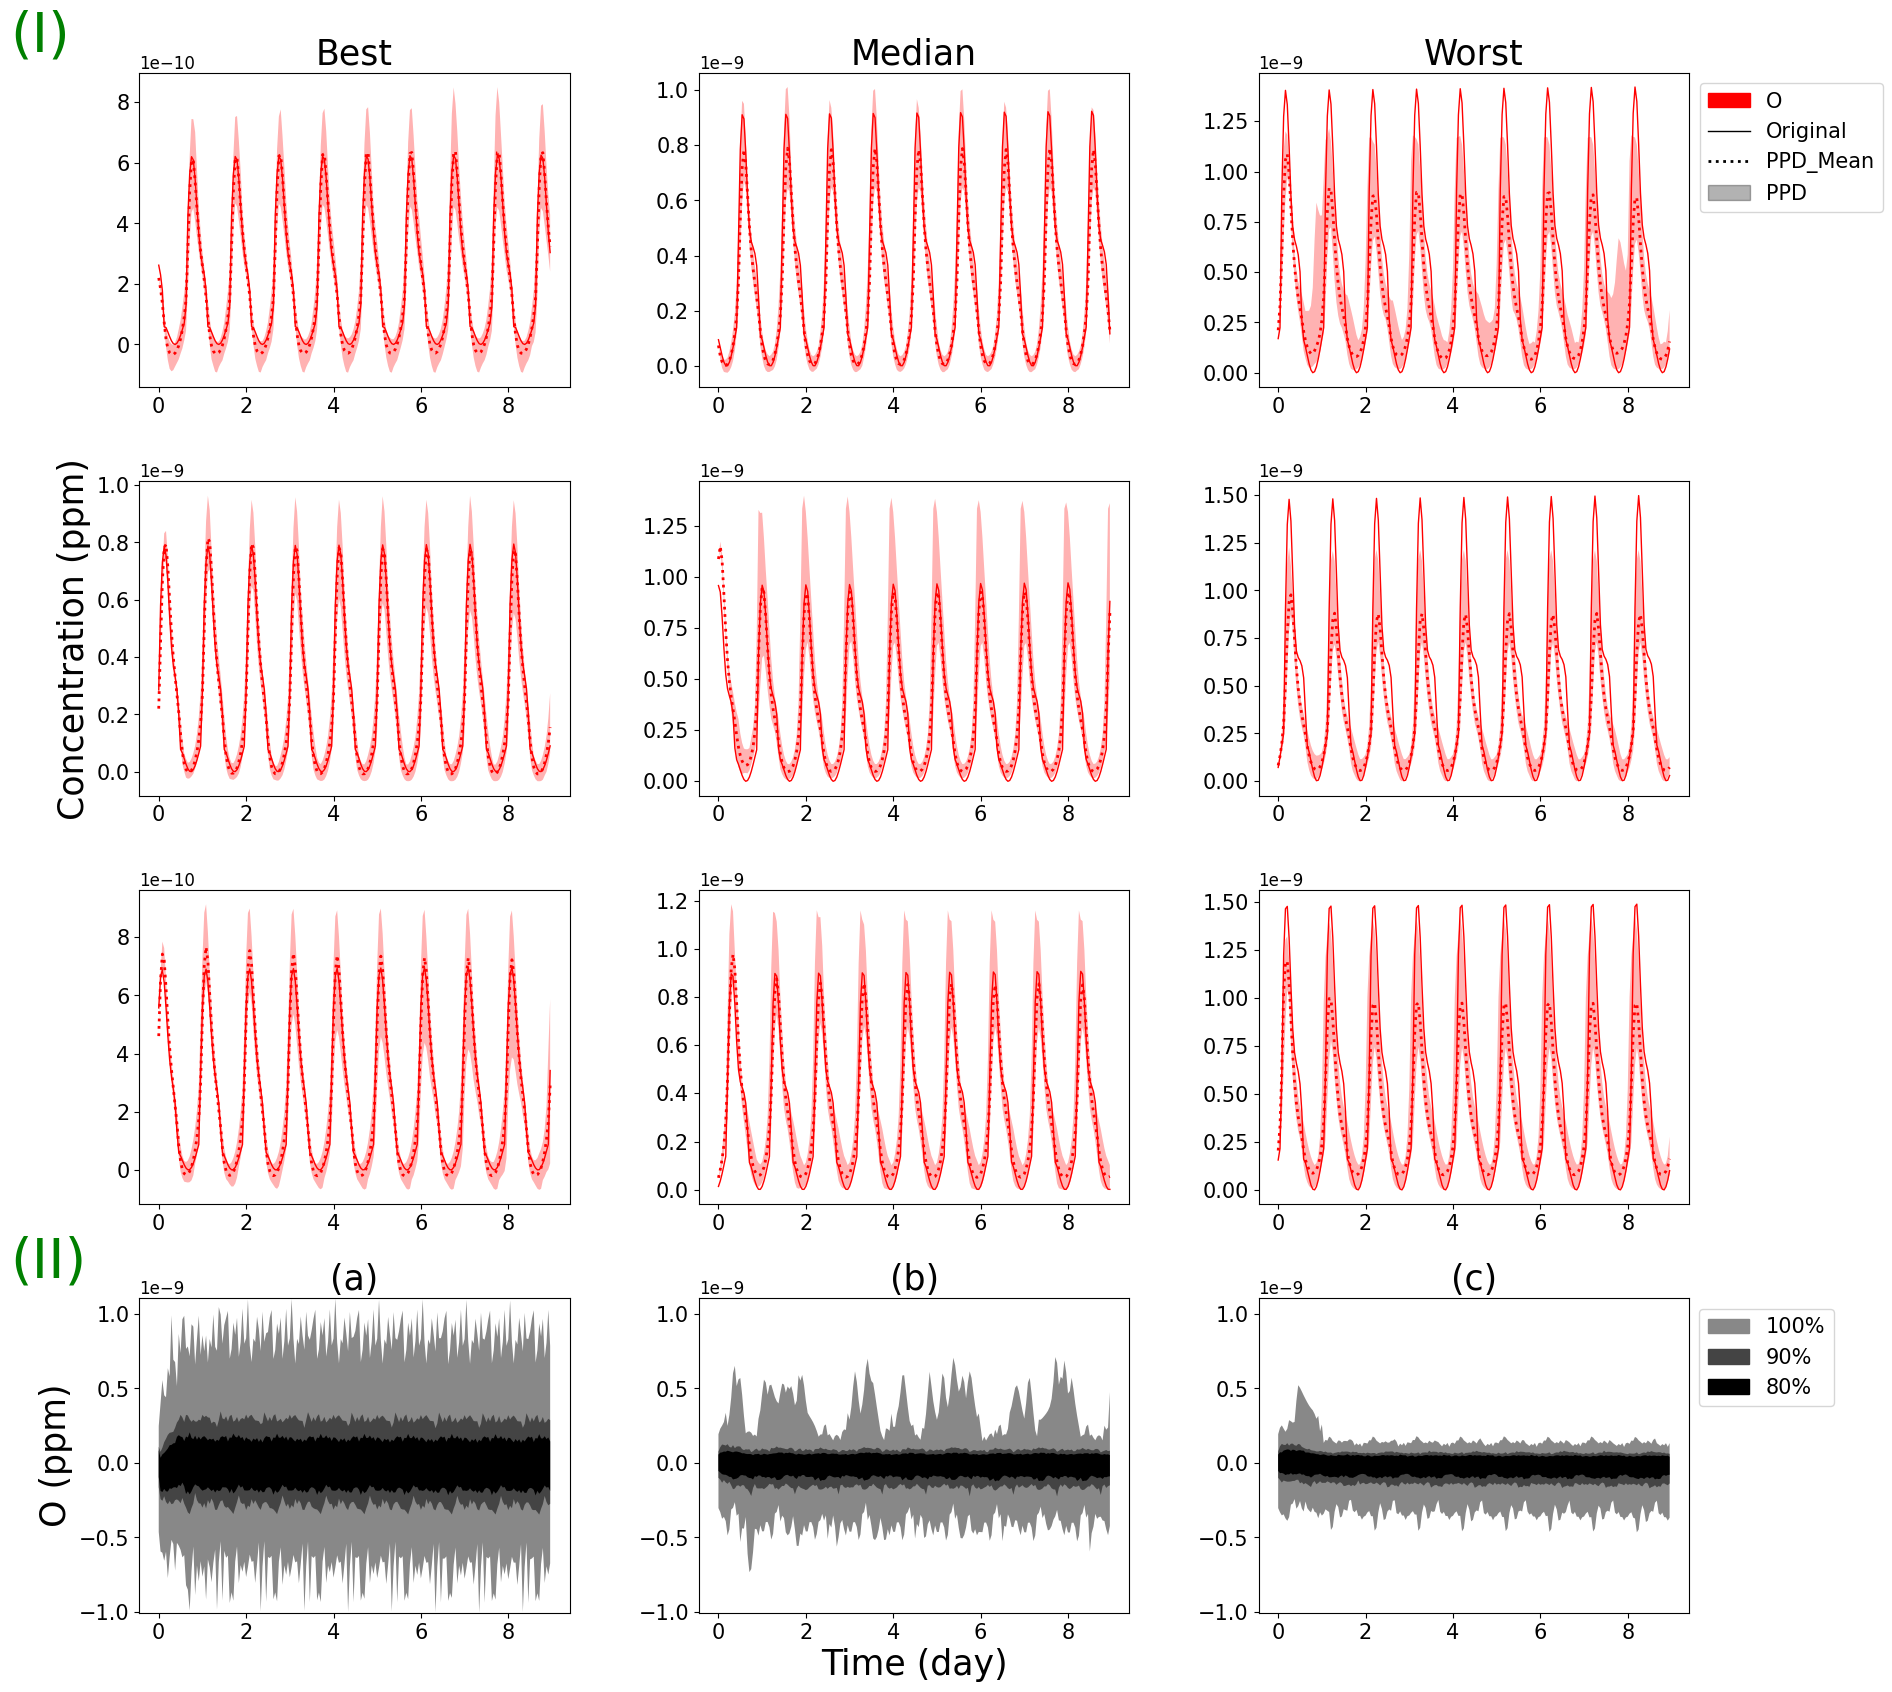

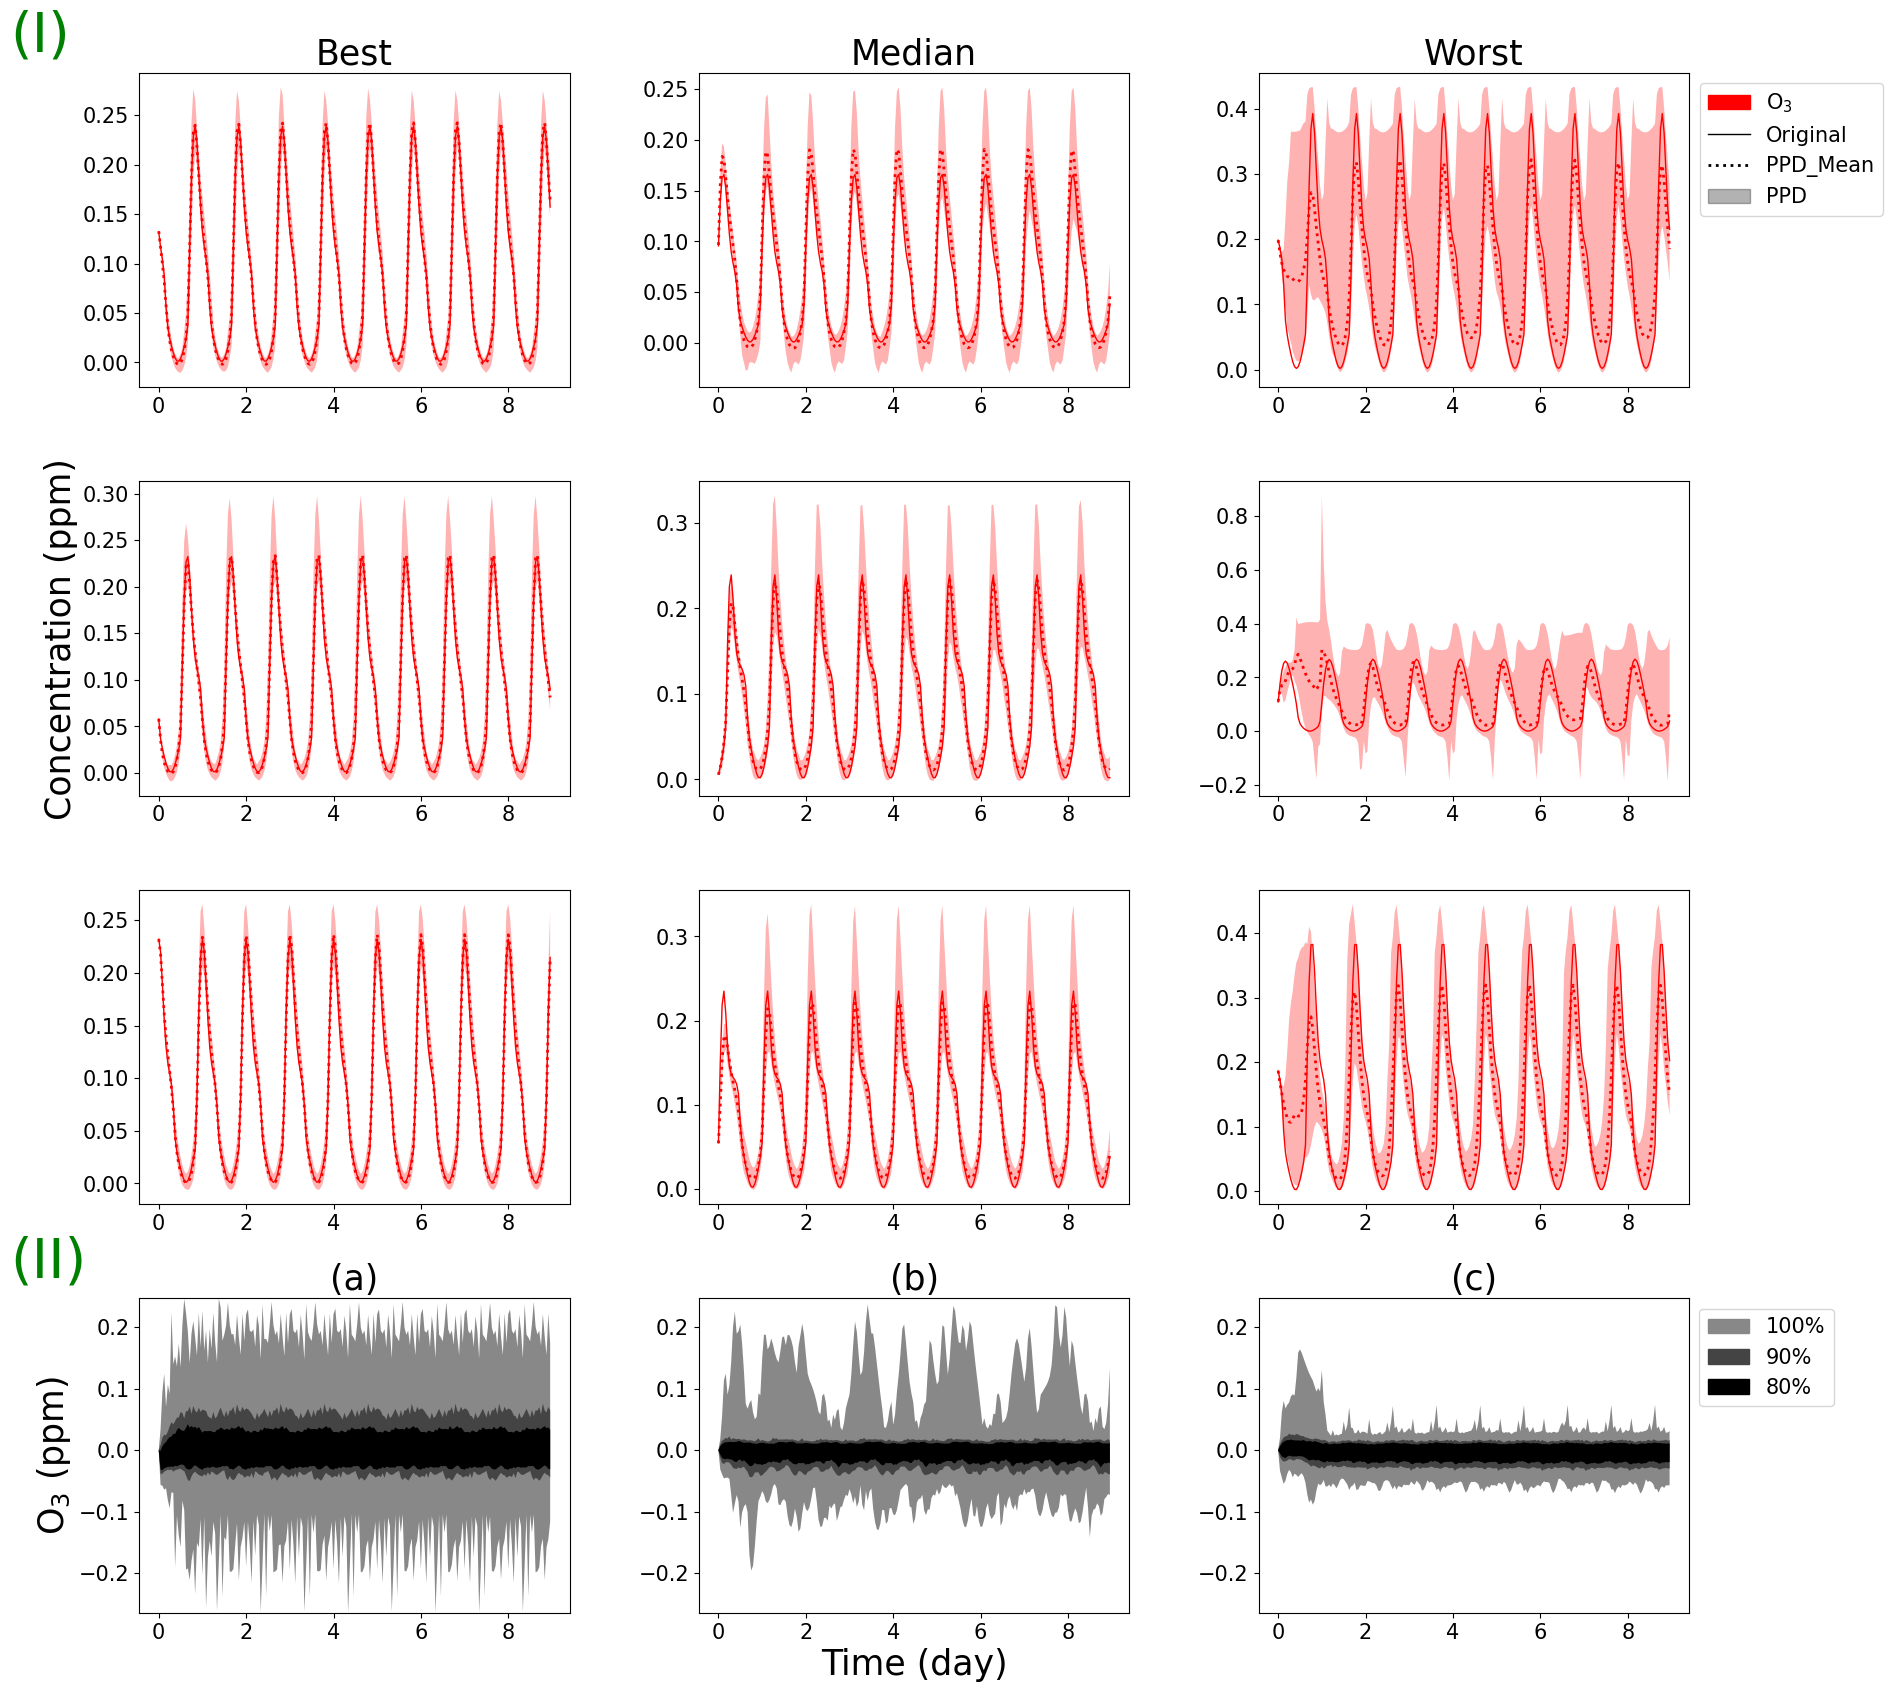

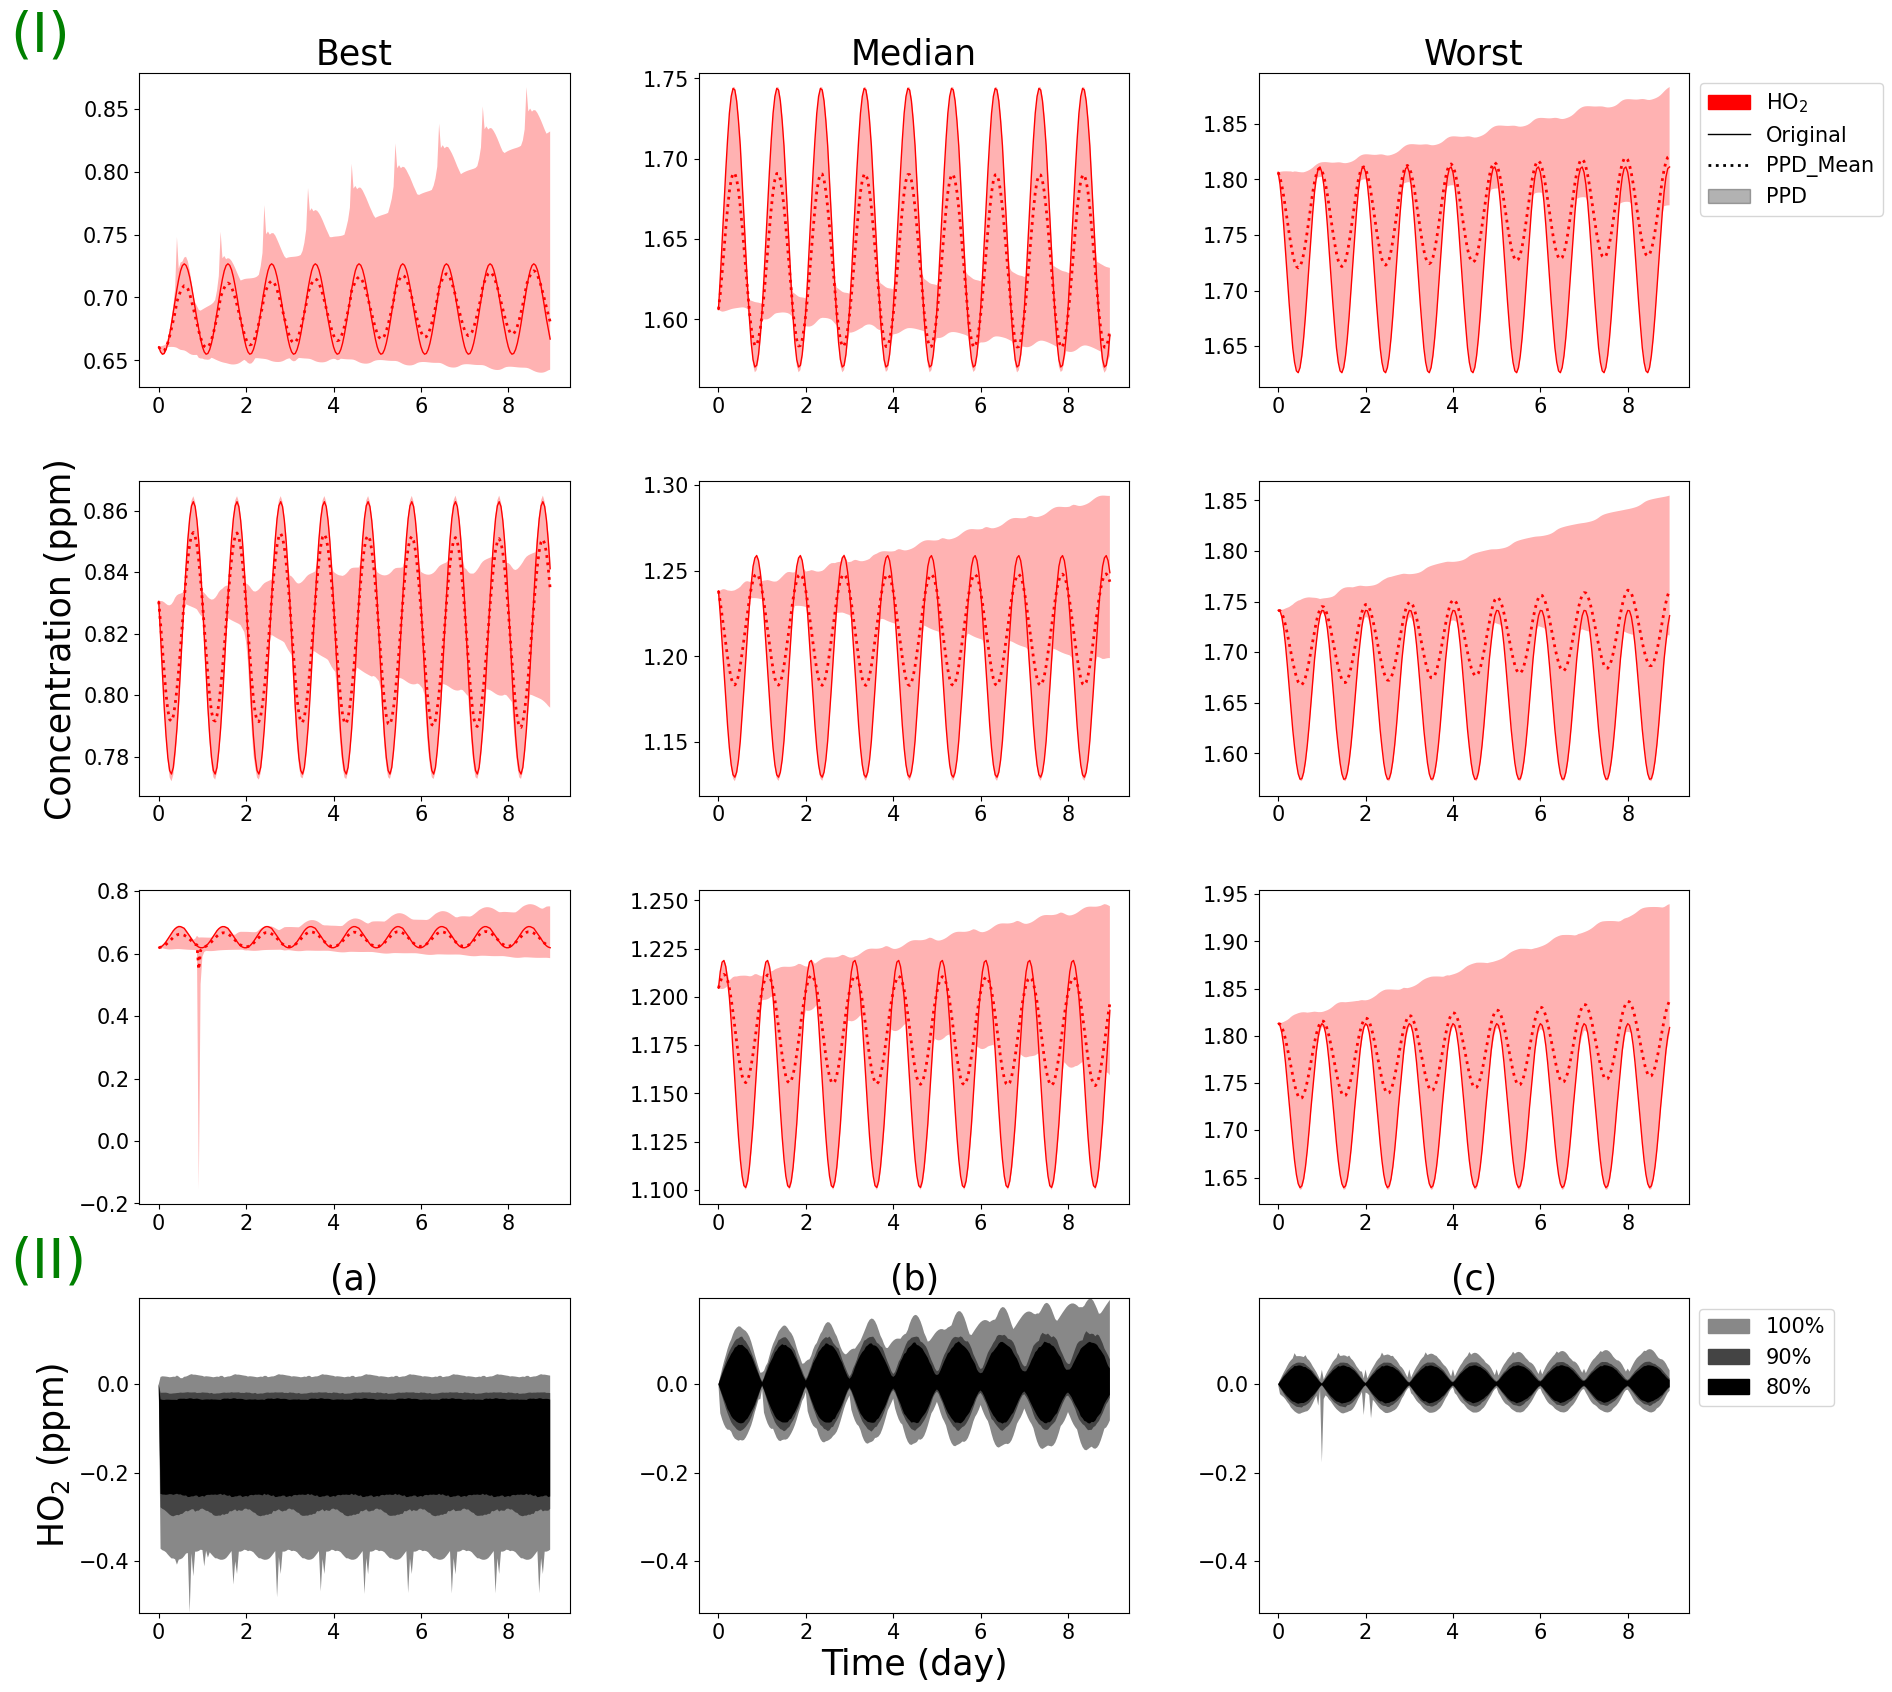

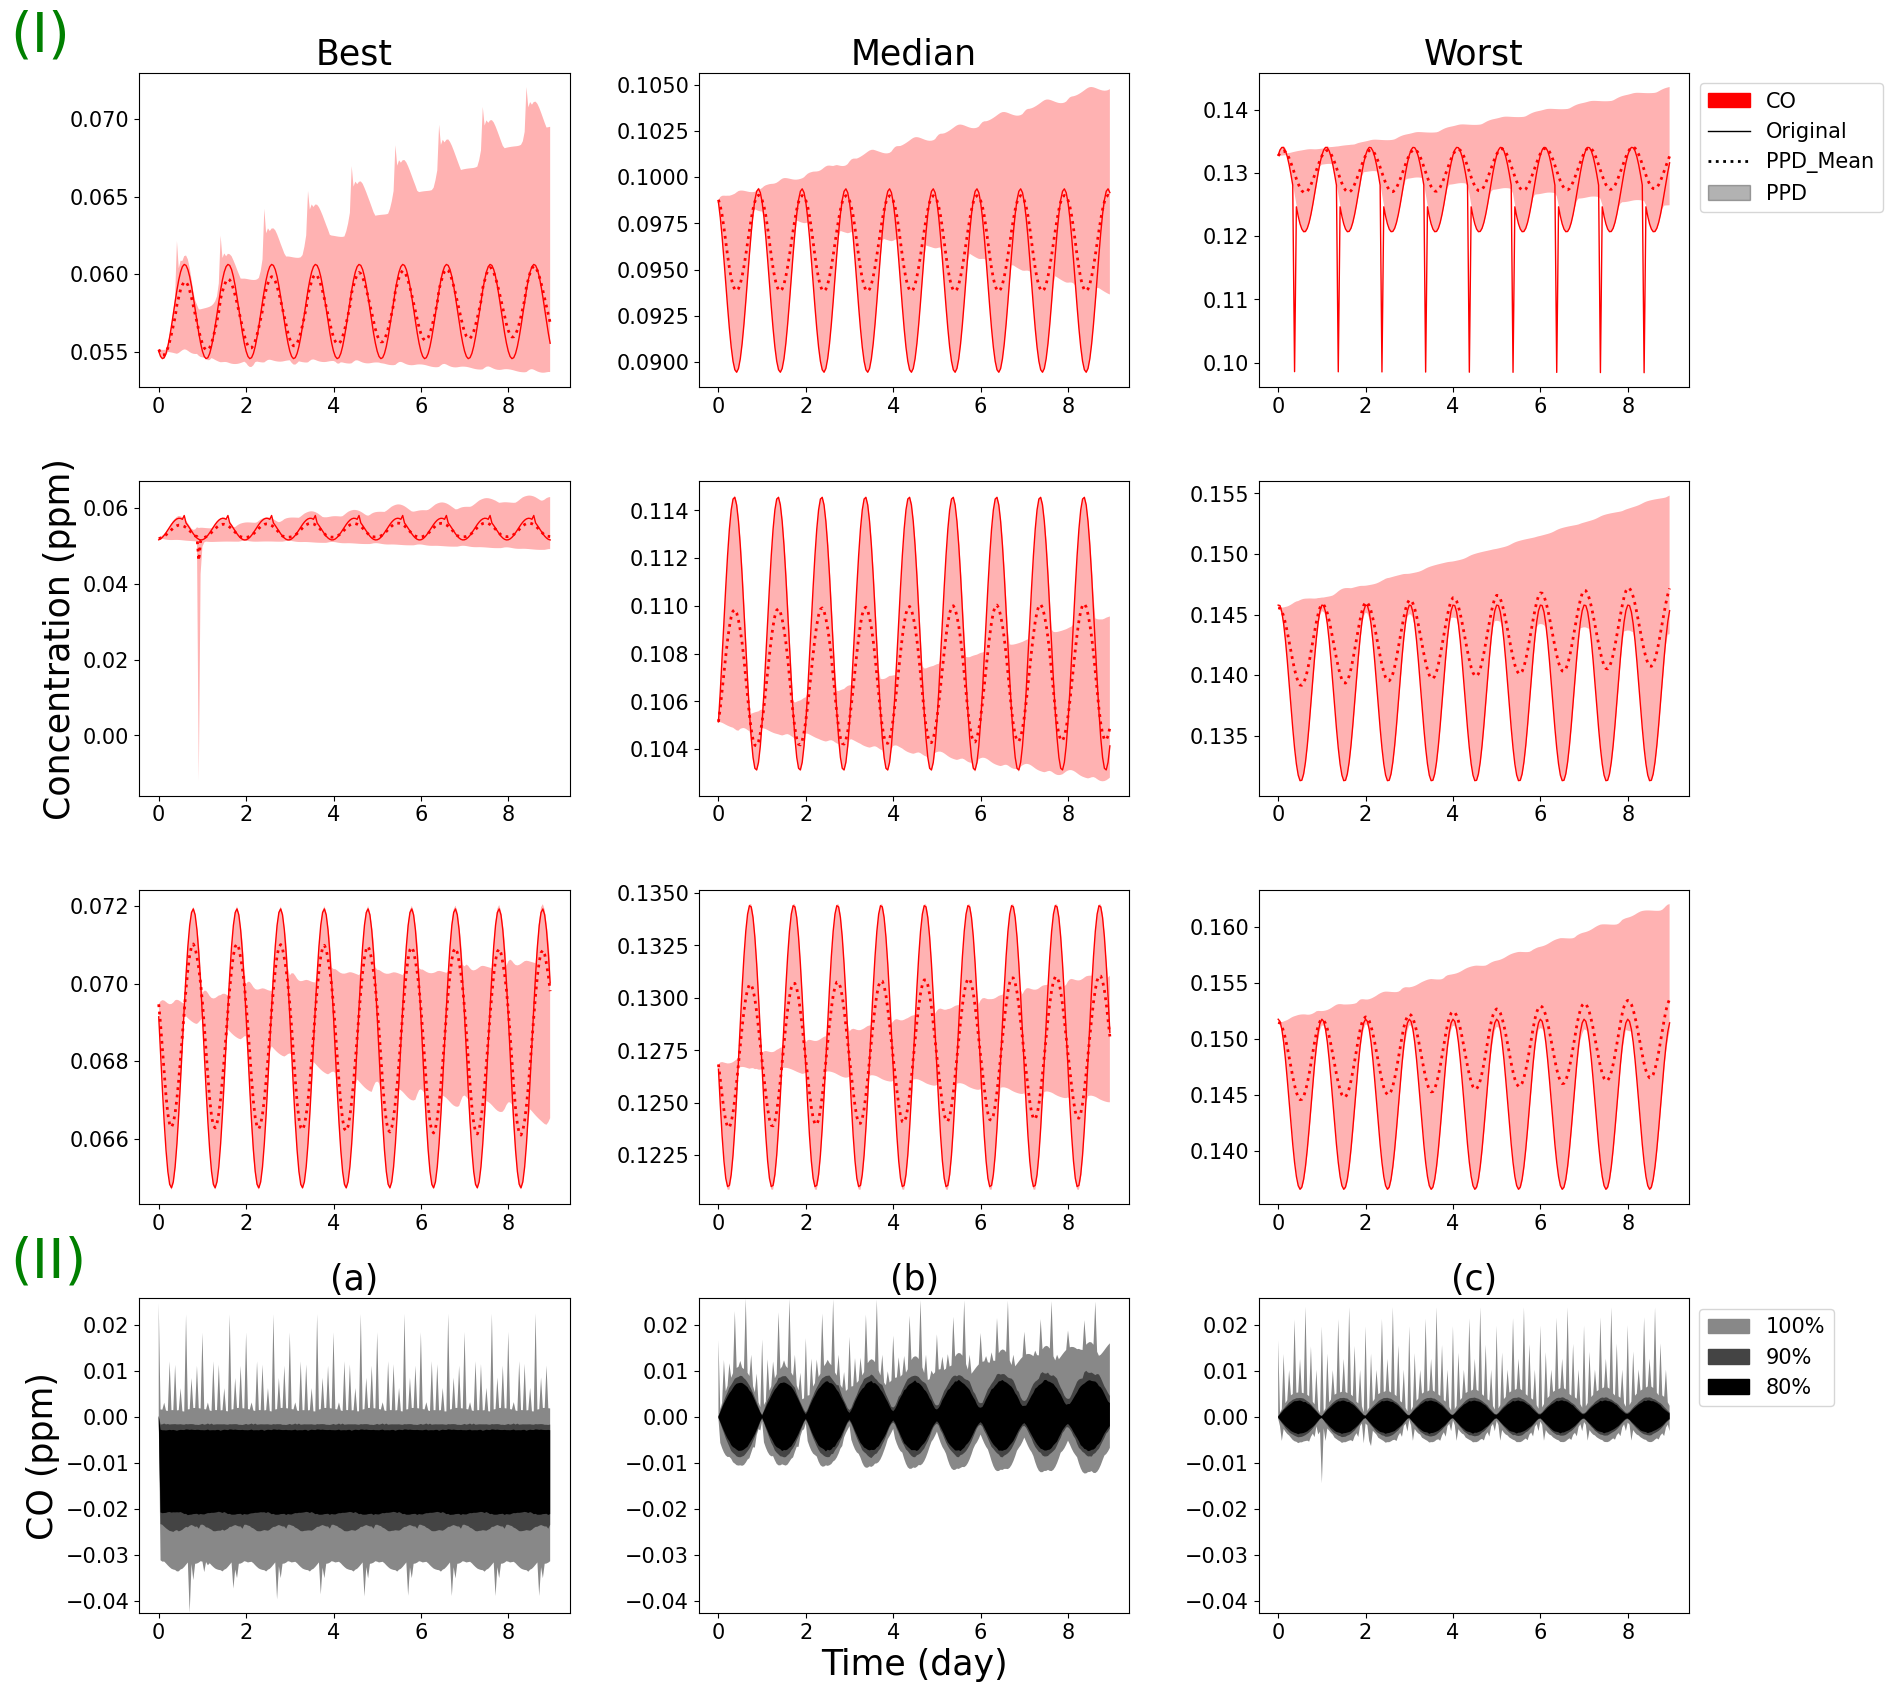

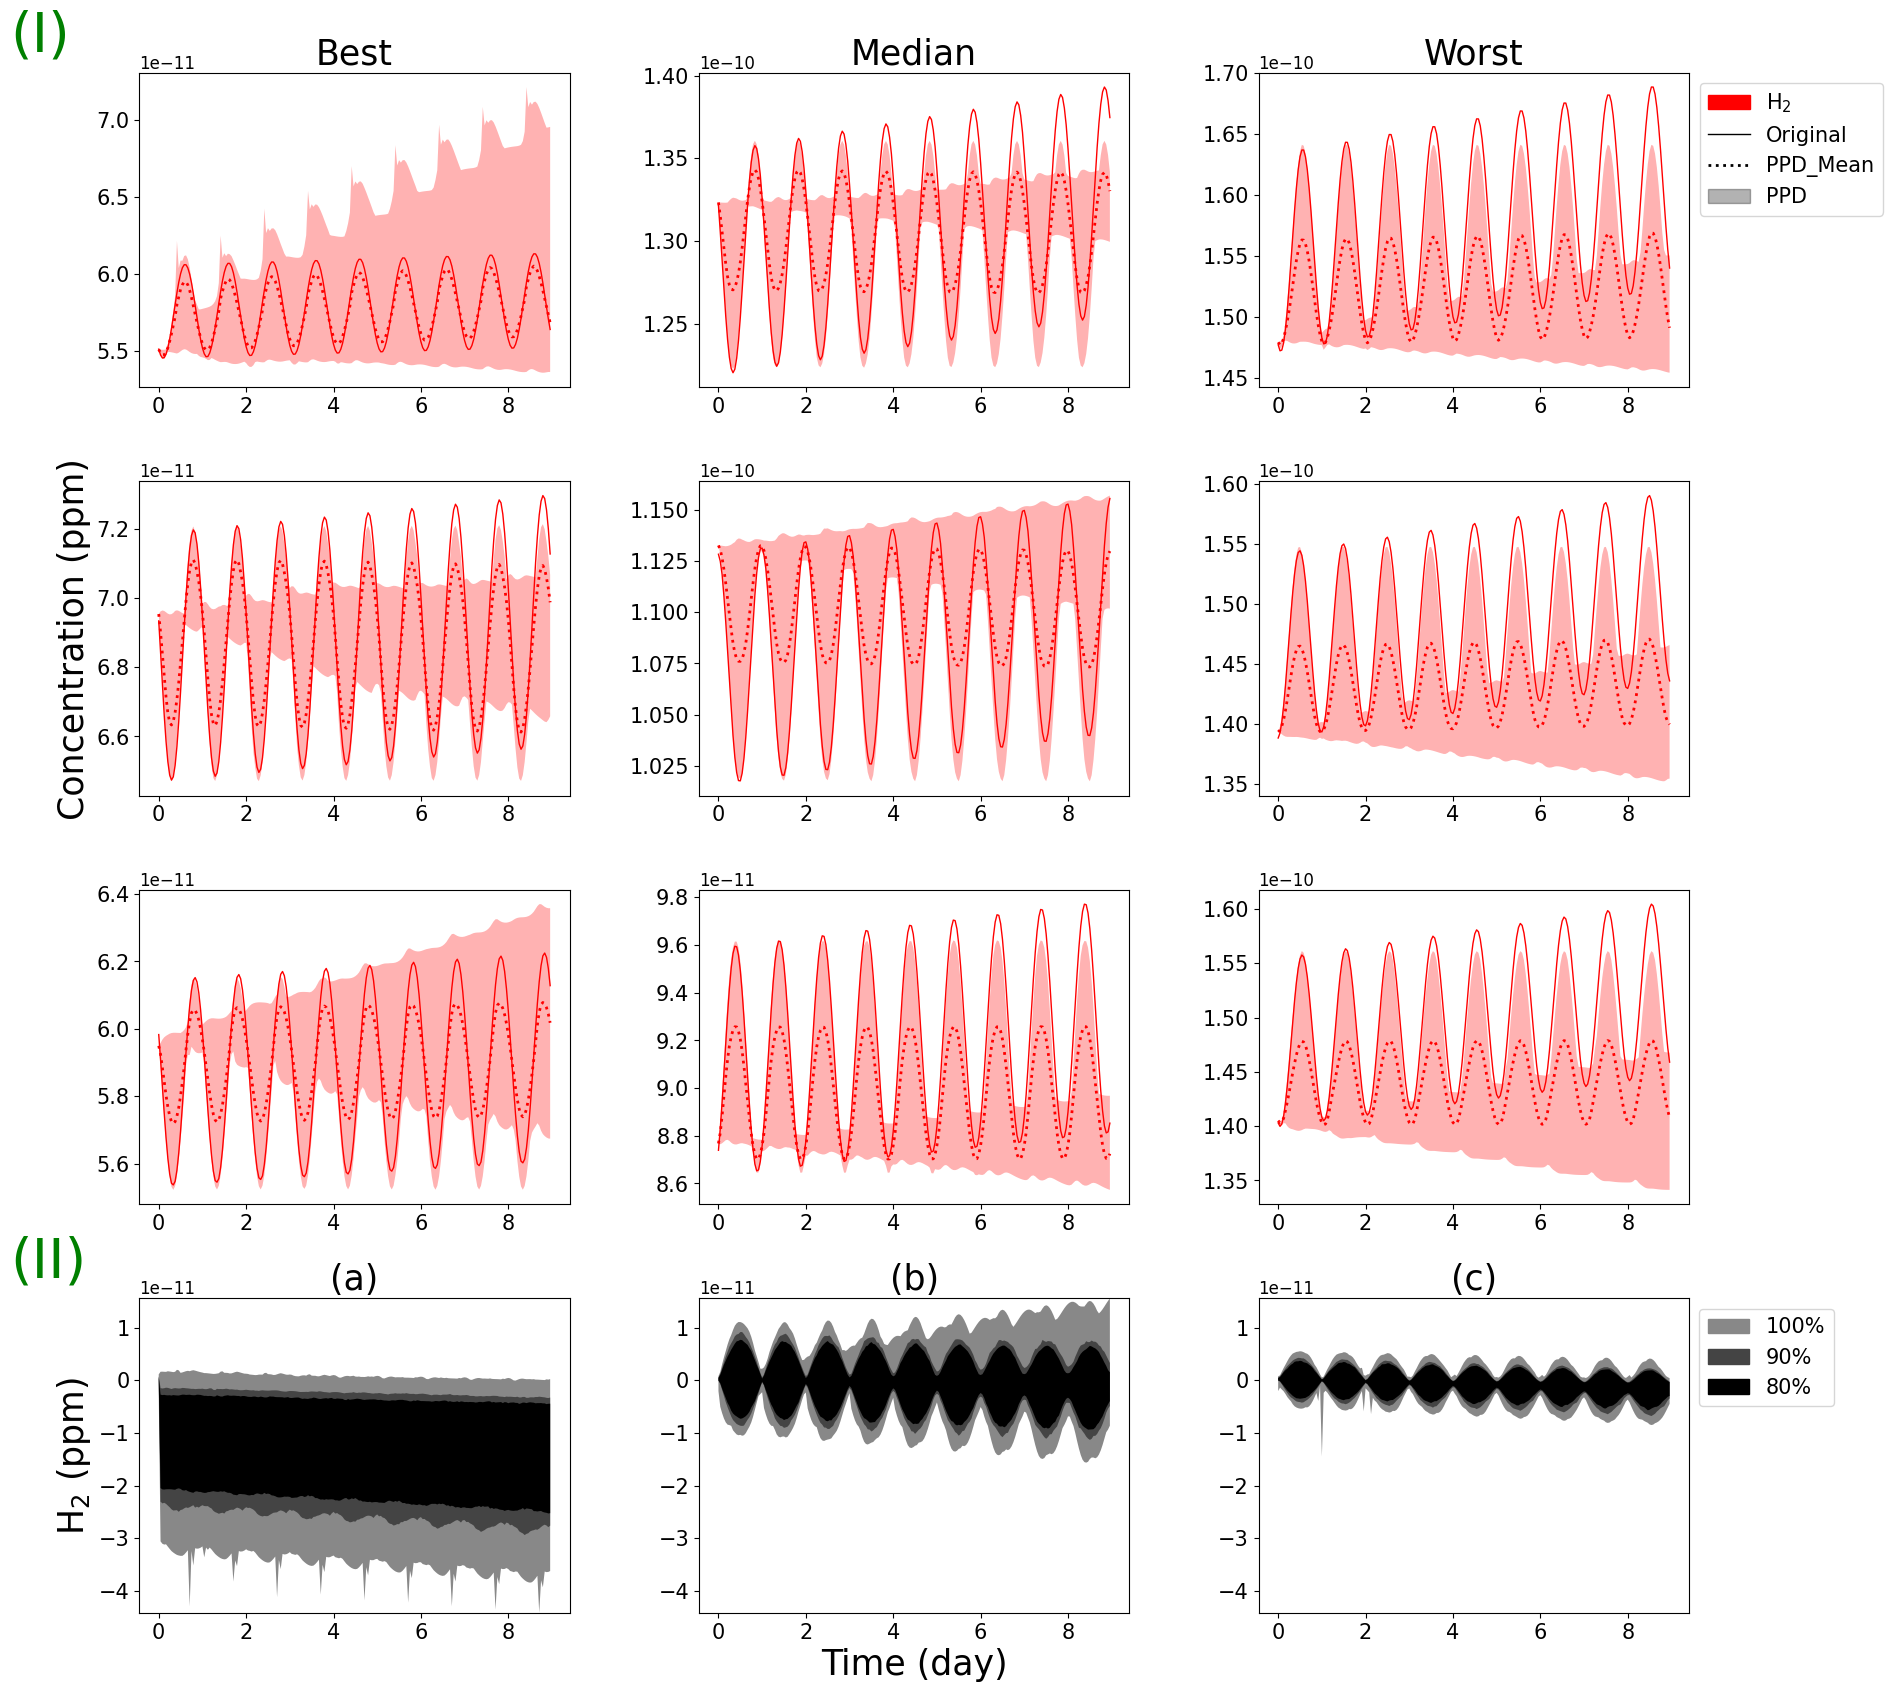

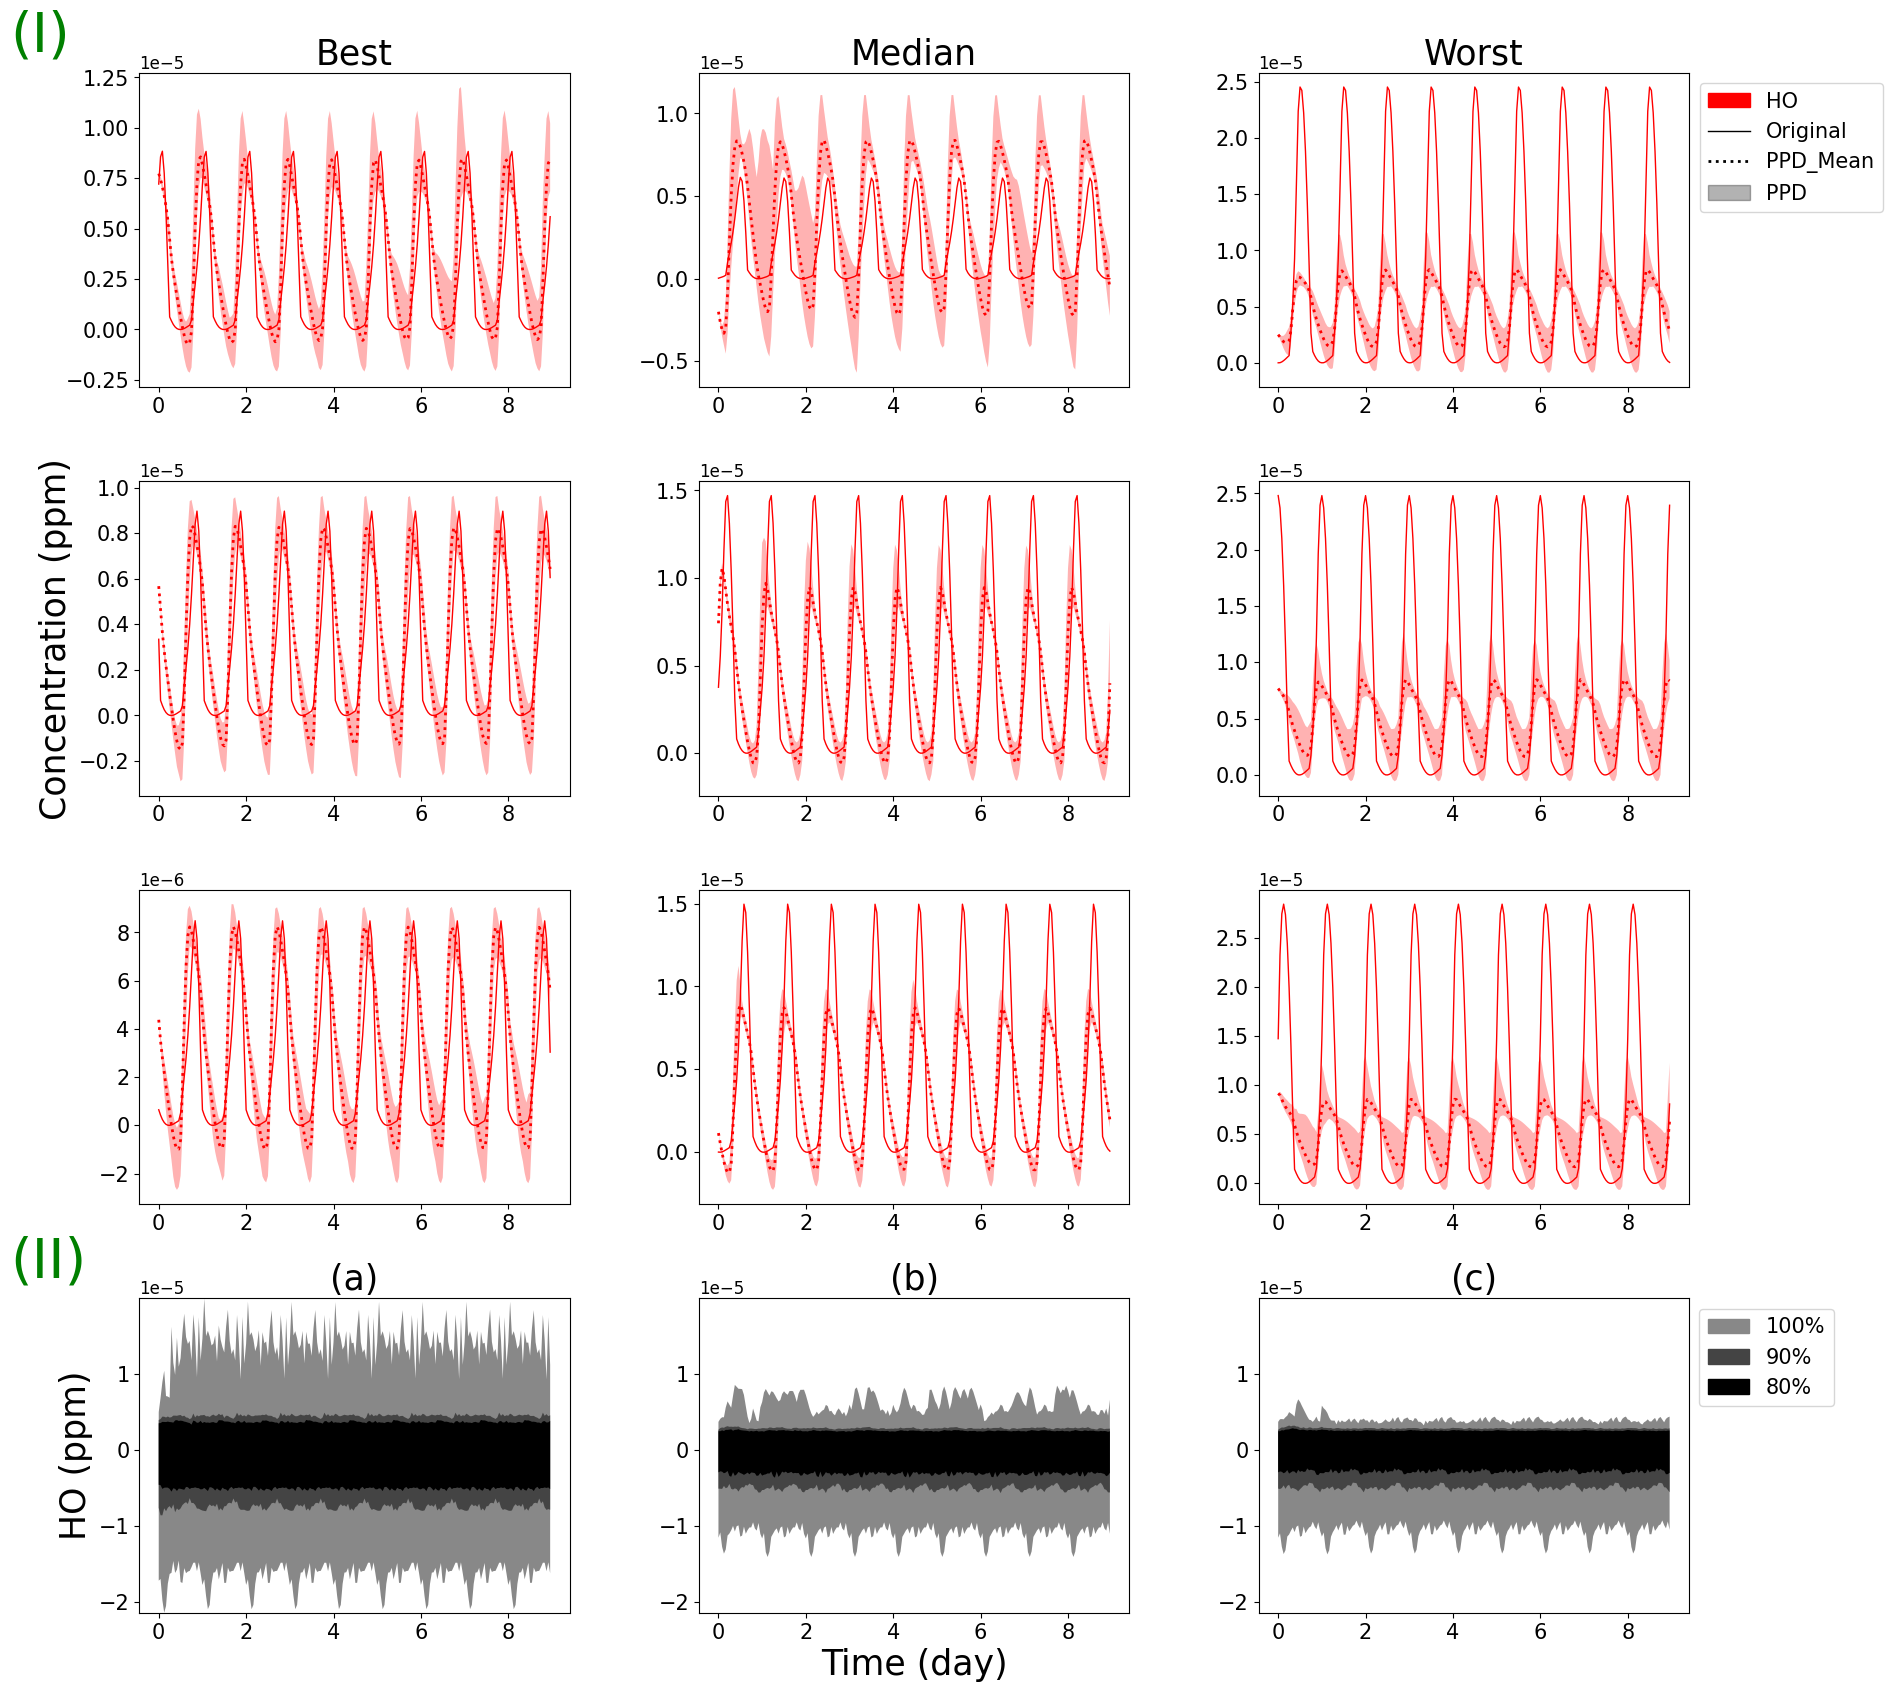

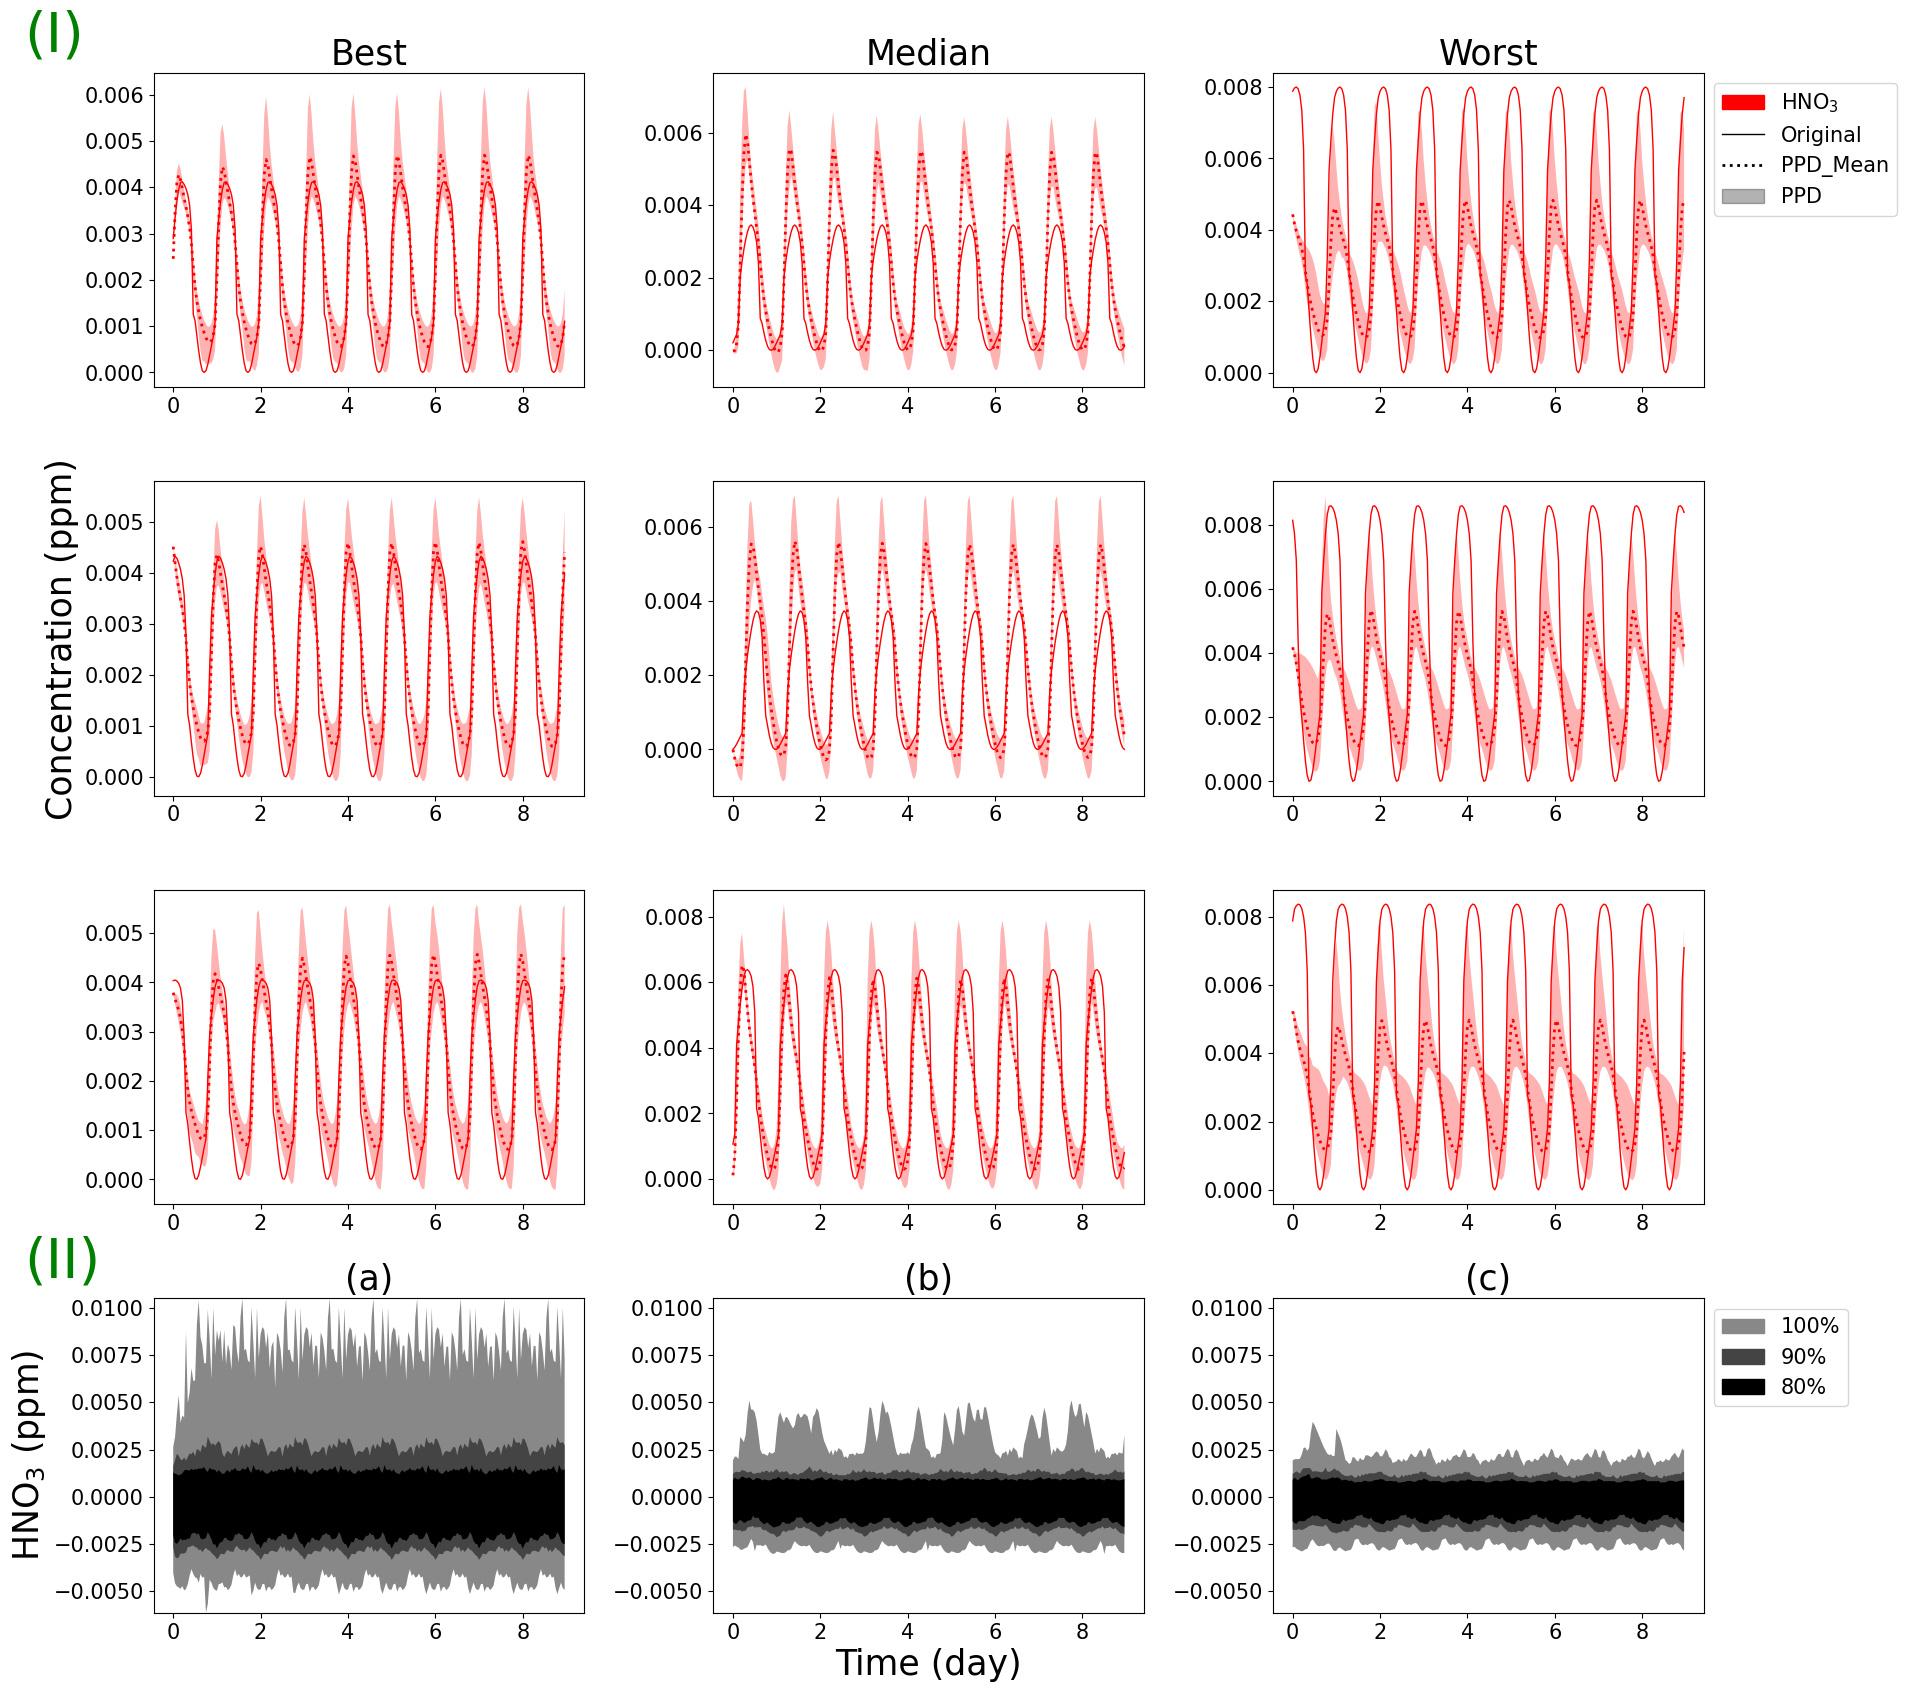

In [110]:
for spec_idx in range(len(specs_name)):
    rmse_ = np.mean(np.abs((np.stack(mean_sims)-ref_data_test)[:,:,spec_idx]/EO), 1)
    enum_list = list(enumerate(rmse_))
    sorted_enum_list = sorted(enum_list, key=lambda x: x[1])
    smallest_indices = [index for index, value in sorted_enum_list[:3]]
    largest_indices = [index for index, value in sorted_enum_list[-3:]]
    list_length = len(sorted_enum_list)
    middle = list_length // 2

    median_indices = [sorted_enum_list[middle-1][0], sorted_enum_list[middle][0], sorted_enum_list[middle+1][0]]


    color=['red']
    specs = specs_name[spec_idx]
    n = len(color)
    legend_elements1 = [Patch(facecolor=color[i], edgecolor=color[i], label=specs) for i in range(n)]
    legend_elements1 += [Line2D([0], [0], color='black', lw=1, label='Original'),
                        Line2D([0], [0], color='black', linestyle=':', lw=2,label='PPD_Mean'),
                       Patch(facecolor='black', edgecolor='black', label='PPD', alpha=0.3)]

    colors=color

    indexex = [smallest_indices, median_indices, largest_indices]
    figure, ax = plt.subplots(4, 3, figsize=(20, 20))
    for i in range(3):
        for j in range(3):
            idx = indexex[j][i]

            below = below_sims[idx]
            above = above_sims[idx]
            post_mean = mean_sims[idx]
            sim = inv_transform(sims[idx])

            ax[i,j].set_prop_cycle(color=colors)
            ax[i,j].plot((times_test-1500)/60/24, ref_data_test[idx][:,spec_idx],linewidth=1)
            ax[i,j].plot((times_test-1500)[:len(post_mean)]/60/24, post_mean[:,spec_idx],  linestyle=':', linewidth=2)


            ax[i,j].fill_between((times_test-1500)[:len(sim)]/60/24, below[:, spec_idx], above[:, spec_idx], alpha=0.3)
            ax[i,j].xaxis.set_tick_params(labelsize=15)
            ax[i,j].yaxis.set_tick_params(labelsize=15)
            ax[i,j].yaxis.offsetText.set_fontsize(12)
            if j==0 and i==1:
                ax[i,j].set_ylabel('Concentration (ppm)', fontsize=25)
            if i==0 and j==0:
                ax[i,j].set_title('Best', fontsize=25)
                ax[i,j].text(-0.3, 1.2, '(I)', fontsize=40, color='green', transform=ax[i,j].transAxes, va='top')
            if i==0 and j==1:
                ax[i,j].set_title('Median', fontsize=25)
            if i==0 and j==2:
                ax[i,j].set_title('Worst', fontsize=25)
                ax[i,j].legend(handles=legend_elements1, bbox_to_anchor=(1,1), fontsize = 15)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    ax1, ax2, ax3 = ax[3,0], ax[3,1], ax[3,2]
    ax1.set_prop_cycle(color=['#888','#444','black'])
    ax2.set_prop_cycle(color=['#888','#444','black'])
    ax3.set_prop_cycle(color=['#888','#444','black'])
    legend_elements1 = [Patch(facecolor='#888', edgecolor='#888', label='100%'),
                      Patch(facecolor='#444', edgecolor='#444', label='90%'),
                      Patch(facecolor='black', edgecolor='black', label='80%')]

    error_CI = [0, 10, 20]
    upper_ylim = -float('inf')
    lower_ylim = float('inf')
    for ci in error_CI:
        upper = np.percentile((SINDy_pred-SINDy_test)[:,:,spec_idx],100-ci/2, axis=0)
        lower = np.percentile((SINDy_pred-SINDy_test)[:,:,spec_idx],ci/2, axis=0)
        upper_ylim = max(upper_ylim, np.max(upper))
        lower_ylim = min(lower_ylim, np.min(lower))
        ax1.fill_between((times_test-1500)[:len(upper)]/60/24, lower, upper)

    for ci in error_CI:
        upper = np.percentile((sims_best-ref_data_test)[:,:,spec_idx]/EO,100-ci/2, axis=0)
        lower = np.percentile((sims_best-ref_data_test)[:,:,spec_idx]/EO,ci/2, axis=0)
        upper_ylim = max(upper_ylim, np.max(upper))
        lower_ylim = min(lower_ylim, np.min(lower))
        ax2.fill_between((times_test-1500)[:len(upper)]/60/24, lower, upper)

    for ci in error_CI:
        upper = np.percentile((np.stack(mean_sims)-ref_data_test)[:,:,spec_idx]/EO,100-ci/2, axis=0)
        lower = np.percentile((np.stack(mean_sims)-ref_data_test)[:,:,spec_idx]/EO,ci/2, axis=0)
        upper_ylim = max(upper_ylim, np.max(upper))
        lower_ylim = min(lower_ylim, np.min(lower))
        ax3.fill_between((times_test-1500)[:len(upper)]/60/24, lower, upper)
    ax3.legend(handles=legend_elements1, bbox_to_anchor=(1.36,1), fontsize = 15)
    ax1.text(-0.3, 1.2, '(II)', fontsize=40,color='green', transform=ax1.transAxes, va='top')
    ax1.xaxis.set_tick_params(labelsize=15)
    ax1.yaxis.set_tick_params(labelsize=15)
    ax1.set_ylim(lower_ylim, upper_ylim)
    ax2.set_ylim(lower_ylim, upper_ylim)
    ax3.set_ylim(lower_ylim, upper_ylim)
    ax1.yaxis.offsetText.set_fontsize(12)
    ax2.yaxis.offsetText.set_fontsize(12)
    ax3.yaxis.offsetText.set_fontsize(12)
    
    ax2.xaxis.set_tick_params(labelsize=15)
    ax2.yaxis.set_tick_params(labelsize=15)
    ax3.xaxis.set_tick_params(labelsize=15)
    ax3.yaxis.set_tick_params(labelsize=15)
    ax1.set_ylabel(str(specs)+ " (ppm)", fontsize=25)
    ax2.set_xlabel("Time (day)", fontsize=25)
    ax1.set_title("(a)", fontsize=25)
    ax2.set_title("(b)", fontsize=25)
    ax3.set_title("(c)", fontsize=25)
    
    plt.savefig('figure\\figS1_'+str(specs_name_[spec_idx])+'.pdf', format='pdf', dpi=1200, bbox_inches="tight")

### Plot error distribution among different ensemble menbers and cases

In [111]:
with open("result\\1000_ensemble_375_test_ESINDy_depo.npy", 'rb') as f:
        ensemble_pred = np.load(f)
with open("result\\1000_ensemble_375_test_ESINDy_stable_depo.npy", 'rb') as f:
        stable_ensemble = np.load(f)

In [112]:
mse = -np.ones(np.stack(stable_ensemble).shape)
mse_O3 = -np.ones(np.stack(stable_ensemble).shape)
def inv_transform(x):
    return scalar.inverse_transform(pca.inverse_transform(x))


for i in trange(1000):
    for j in range(375):
        if stable_ensemble[i][j]==1:
            if np.max(abs(ensemble_pred[i][j]))<5:
                mse[i,j] = calc_rmse(inv_transform(ensemble_pred[i][j]),ref_data_test[j])
                mse_O3[i,j] = calc_rmse_O3(inv_transform(ensemble_pred[i][j]),ref_data_test[j])
            else:
                stable_ensemble[i][j]=0

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 30.11it/s]


In [116]:
selected = np.ones(1000)
selected[ind]=0
selected = selected==0

C:\Users\Dio\AppData\Local\Temp\ipykernel_17660\2500191128.py:1: RuntimeWarning: invalid value encountered in log10
  log_mse = np.log10(mse)


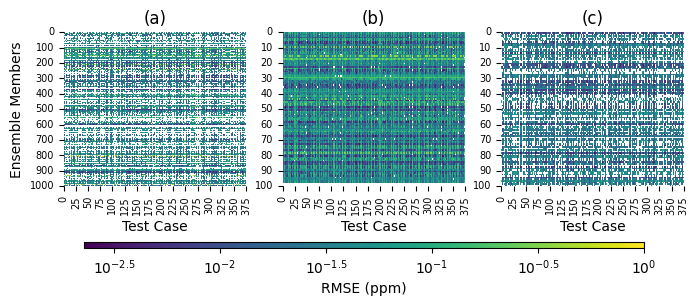

In [117]:
log_mse = np.log10(mse)
mse_bool = log_mse==-1
import seaborn as sns
x = np.arange(0, 400, 25)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (8,2))
sns.heatmap(log_mse, ax=ax1, cmap="viridis", mask=mse_bool, vmax=np.nanmax(log_mse), vmin = np.nanmin(log_mse), cbar=False)
sns.heatmap(log_mse[over95,:], ax=ax2, cmap="viridis", mask=mse_bool[over95,:], vmax=np.nanmax(log_mse), vmin = np.nanmin(log_mse), cbar=False)
sns.heatmap(log_mse[selected,:], ax=ax3, cmap="viridis", mask=mse_bool[selected,:], vmax=np.nanmax(log_mse), vmin = np.nanmin(log_mse), cbar=False)

ax1.set_ylabel("Ensemble Members")
ax1.set_xlabel("Test Case")
ax1.tick_params(labelsize=7)
ax1.set_xticks(x)
ax1.set_xticklabels([str(a) for a in x])
ax1.set_yticks(np.arange(0, 1000+100, 100))
ax1.set_yticklabels([str(a) for a in np.arange(0, 1000+100, 100)])

ax2.set_xlabel("Test Case")
ax2.tick_params(labelsize=7)
ax2.set_xticks(x)
ax2.set_xticklabels([str(a) for a in x])
ax2.set_yticks(np.arange(0, np.sum(over95)+10, 10))
ax2.set_yticklabels([str(a) for a in np.arange(0, np.sum(over95)+10, 10)])

ax3.set_xlabel("Test Case")
ax3.tick_params(labelsize=7)
ax3.set_xticks(x)
ax3.set_xticklabels([str(a) for a in x])
ax3.set_yticks(np.arange(0, 100+10, 10))
ax3.set_yticklabels([str(a) for a in np.arange(0, 100+10, 10)])


plt.yticks(rotation=0)
ax1.set_title("(a)")
ax2.set_title("(b)")
ax3.set_title("(c)")

cbar_ax = fig.add_axes([0.15, -0.2, 0.7, 0.03])  # Adjust the position as needed
cbar = fig.colorbar(ax1.collections[0], cax=cbar_ax, orientation="horizontal")
cbar.set_ticks([0, -0.5, -1, -1.5, -2, -2.5])
cbar.set_ticklabels(['10$^0$', '10$^{-0.5}$', '10$^{-1}$','10$^{-1.5}$', '10$^{-2}$', '10$^{-2.5}$'])
cbar.set_label('RMSE (ppm)')
plt.savefig('figure\\testingRMSEs.pdf', format='pdf', dpi=600, bbox_inches="tight")

## 5. Effect of different inclusion probability threshold

In [119]:
with open('result\\ensemble_coef_ESINDy_newdata_30per_row_30_col_depo_top_10.npy', 'rb') as f:
    ensemble_coef = np.load(f)

In [120]:
coefs = np.stack(ensemble_coef)

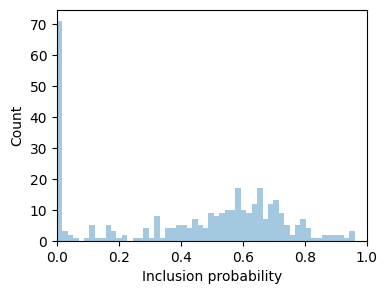

In [122]:
import seaborn as sns

plt.figure(figsize=(4,3))
sns.distplot(np.mean(coefs!=0, 0).reshape(339,), hist=True, kde=False, bins=55)
plt.xlabel('Inclusion probability')
plt.ylabel('Count')
plt.xlim(0, 1.0)
g.set_xticks(np.linspace(0,1,11))
plt.savefig('figure\\inclusionprobability.svg', format='svg', dpi=1200, bbox_inches="tight")

In [123]:
ips = [0, 0.5, 0.7]
with open('result\\ensemble_coef_ESINDy_newdata_30per_row_30_col_depo_top_10.npy', 'rb') as f:
    ensemble_coef = np.load(f)
    
for ip in ips:
    print("Current inclusion probability: ", ip)
    ensemble_coef_temp = ensemble_coef.copy()
    coef_mask = np.mean(coefs!=0, 0)<ip
    for i in range(100):
        ensemble_coef_temp[i][coef_mask]=0
        
    mean_ensemble = np.mean(ensemble_coef_temp, axis=0)
    median_ensemble = np.median(ensemble_coef_temp, axis=0)
    ensembles = (("mean", mean_ensemble), ("median", median_ensemble))
    for ensemble in ensembles:
        print("------------------------------------------------------------------------------")
        print(ensemble[0])
        rhs = make_lsoda_func(ensemble[1])
        funcptr = rhs.address
        u0s = np.stack(test_pca)[:,0,:]
        Us = np.stack(multi_U_test1)
        time_test = times_test-1500
        @nb.njit(parallel=True)
        def simulate():
            sol = np.empty((375, 216, 3))
            succ = np.empty(375)
            for i in nb.prange(375):
                u0 = u0s[i]
                p = Us[i]
                usol, success = lsoda(funcptr, u0, time_test, data = p, rtol=1.0e-3, atol=1.0e-6)
                if len(np.argwhere(np.isnan(usol)))!=0 or np.max(np.abs(usol))>5:
                    success = 0
                sol[i] = usol
                succ[i] = success
            return sol, succ
        sims, succ = simulate()
        
        rmse = np.mean([calc_rmse(inv_transform(sims[i]),ref_data_test[i]) for i in np.where(succ==1)[0]])
        rmse_O3 = np.mean([calc_rmse_O3(inv_transform(sims[i]),ref_data_test[i]) for i in np.where(succ==1)[0]])
        print(f"rmse: {np.round(rmse,4)}, rmse_O3: {np.round(rmse_O3, 4)}")
        print("number of stably solved cases: ", np.sum(succ))
        
    ensemble_pred = []
    stable_ensemble = []
    for i in trange(len(ensemble_coef_temp)):
        rhs = make_lsoda_func(ensemble_coef_temp[i])
        funcptr = rhs.address
        u0s = np.stack(test_pca)[:,0,:]
        Us = np.stack(multi_U_test1)
        time_test = times_test-1500
        @nb.njit(parallel=True)
        def simulate():
            sol = np.empty((375, 216, 3))
            succ = np.empty(375)
            for i in nb.prange(375):
                u0 = u0s[i]
                p = Us[i]
                usol, success = lsoda(funcptr, u0, time_test, data = p, rtol=1.0e-3, atol=1.0e-6)
                if len(np.argwhere(np.isnan(usol)))!=0 or np.max(np.abs(usol))>5:
                    success = 0
                sol[i] = usol
                succ[i] = success
            return sol, succ
        sims, succ = simulate()
        ensemble_pred.append(sims)
        stable_ensemble.append(succ)

    mse = -np.ones(np.stack(stable_ensemble).shape)
    mse_O3 = -np.ones(np.stack(stable_ensemble).shape)
    def inv_transform(x):
        return scalar.inverse_transform(pca.inverse_transform(x))


    for i in trange(100):
        for j in range(375):
            if stable_ensemble[i][j]==1:
                if np.max(abs(ensemble_pred[i][j]))<5:
                    mse[i,j] = calc_rmse(inv_transform(ensemble_pred[i][j]),ref_data_test[j])
                    mse_O3[i,j] = calc_rmse_O3(inv_transform(ensemble_pred[i][j]),ref_data_test[j])
                else:
                    stable_ensemble[i][j]=0

    mean_sims = []
    above_sims = []
    below_sims = []
    for j in trange(375):
        temp = []
        for i in range(100):
            if stable_ensemble[i][j]==1:
                if np.max(abs(ensemble_pred[i][j]))<5:
                    temp.append(inv_transform(ensemble_pred[i][j]))
                else:
                    stable_ensemble[i][j]=0
        mean_sims.append(np.mean(temp, axis=0))

    rmse = calc_rmse(np.stack(mean_sims), ref_data_test)
    rmse_inc = -(rmse - 0.0647)/0.0647 *100
    rmse_O3 = calc_rmse_O3(np.stack(mean_sims), ref_data_test)
    rmse_inc_O3 = -(rmse_O3 - 0.03828)/0.03828 *100

    print(f"rmse: {round(rmse, 4)}")
    print(f"rmse_O3: {round(rmse_O3, 4)}")
    print(f"stable solution rate: {round(np.sum(stable_ensemble)/100/375 *100, 0)}")
    print("/n/n/n/n/n")

Current inclusion probability:  0
------------------------------------------------------------------------------
mean
rmse: 0.0213, rmse_O3: 0.0197
number of stably solved cases:  342.0
------------------------------------------------------------------------------
median
rmse: 0.3008, rmse_O3: 0.4623
number of stably solved cases:  354.0


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:01<00:00, 222.14it/s]


rmse: 0.0296
rmse_O3: 0.0136
stable solution rate: 66.0
/n/n/n/n/n
Current inclusion probability:  0.5
------------------------------------------------------------------------------
mean


E:\anaconda3\envs\GC\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\anaconda3\envs\GC\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


rmse: nan, rmse_O3: nan
number of stably solved cases:  0.0
------------------------------------------------------------------------------
median
rmse: 0.3008, rmse_O3: 0.4623
number of stably solved cases:  354.0


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:00<00:00, 695.73it/s]


rmse: 0.0704
rmse_O3: 0.0316
stable solution rate: 24.0
/n/n/n/n/n
Current inclusion probability:  0.7
------------------------------------------------------------------------------
mean
rmse: 0.2003, rmse_O3: 0.1751
number of stably solved cases:  375.0
------------------------------------------------------------------------------
median
rmse: 0.8162, rmse_O3: 1.1118
number of stably solved cases:  375.0


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:01<00:00, 264.45it/s]

rmse: 0.1108
rmse_O3: 0.1035
stable solution rate: 60.0
/n/n/n/n/n
